Date: 6/10/2018


Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* pandas as pd- for dataframes
* re- to examine date syntax
* matplotlib.pyplo- to plot data
* geopy.distance- to calculate distance given a set of coordinates
* math- use of mathematical operations
* copy- create a deep copy of dataset for testing purposes
* scipy.stats- for linear regression
* numpy- to vectorize equations
* sklearn.linear_model- for linear regression
* sklearn.cross_validation- for selecting training and testing dataset


## 1. Introduction
This project comprises the use of exploratory data analysis and data cleansing techniques to clean a dataset. In doing so we will be exposing and treating any found data anomalies. I will be using the definitions provided to us in the tutorial to define data anomalies.

Data Anomalies can be classified at a high level into three categories:

1. **Syntactic Anomalies**: 
describe characteristics concerning the format and values used for representation of the entities. Syntactic anomalies such as: lexical errors, domain format errors, syntactical error and irregularities.
2. **Semantic Anomalies**: 
hinder the data collection from being a comprehensive and non-redundant representation of the mini-world. These types of anomalies include: Integrity constraint violations, contradictions, duplicates and invalid tuples
3. **Coverage Anomalies**: 
decrease the amount of entities and entity properties from the mini-world that are represented in the data collection. Coverage anomalies are categorized as: missing values and missing tuples.

***Note: for the purpose of this report, I have assumed all missing values are MCAR. Hence, this is the assumption I make throughout the analysis.**



I will systematically analyze the dataset, with the purpose of treating each anomaly. The process is detailed in the following sections.

## 2. Importing Libraries and Reading Dataset

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import geopy.distance
import math
%matplotlib inline
import copy
from scipy.stats import linregress
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split

C:\Users\YOU\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [68]:
df=pd.read_csv('29466695.csv')

## 3. Syntactic Anomalies

To begin the cleaning process, we will start with investigating syntactic anomalies. We will first try to understand the dataset before systematically working through each column.

### Surveying the Dataset
First, the datset is studied to ascertain the syntax of each column. The columns are then analyzed in the succeeding sections.

In [69]:
df.head()

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare
0,ID1574983598,1.0,0.0,31.219,11.0,44.0,-36.600581,146.327914,-38.518996,148.203069,270.142,2018-03-03,08:18:38,264.18,12:42:48,95.91
1,ID1750957119,1.0,0.0,23.799,49.0,37.0,-36.540818,147.326229,-36.544820,143.467588,345.069,2018-07-11,10:27:18,335.54,16:02:50,97.84
2,ID5393864916,3.0,1.0,46.503,40.0,29.0,-37.494093,146.189957,-37.676371,147.488746,116.352,2018-04-26,14:54:12,105.09,16:39:17,200.90
3,ID5698348730,1.0,1.0,33.596,48.0,40.0,-38.896284,144.484038,-37.449914,146.449348,235.578,2018-01-08,17:18:04,231.26,21:09:19,133.94
4,ID1111487122,2.0,0.0,9.516,25.0,44.0,-37.059112,146.937517,-38.584440,148.311254,208.373,2018-05-12,00:46:04,188.01,3:54:04,150.52


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36610 entries, 0 to 36609
Data columns (total 16 columns):
Id                       36588 non-null object
Drone Type               36600 non-null float64
Post Type                36590 non-null float64
Package Weight           36610 non-null float64
Origin Region            36600 non-null float64
Destination Region       36600 non-null float64
Origin Latitude          36610 non-null float64
Origin Longitude         36610 non-null float64
Destination Latitude     36610 non-null float64
Destination Longitude    36610 non-null float64
Journey Distance         36610 non-null float64
Departure Date           36610 non-null object
Departure Time           36610 non-null object
Travel Time              36570 non-null float64
Delivery Time            36610 non-null object
Delivery Fare            36580 non-null float64
dtypes: float64(12), object(4)
memory usage: 4.5+ MB


### b. Id  

Each field in the Id column should start with the characters "ID" followed by 10 digits.

I wrote a function to find all values that did not adhere to this pattern. There were no irregularities other than some missing values.

In [71]:
# checks if first 2 letters of string are ID and then remaining characters are numbers and have length of 10
#returns false if either of these conditions are broken
df_id_check=df.Id.apply(lambda x: x if (str(x)[:2]!='ID' or str(x)[2:].isnumeric()==False or len(str(x)[2:])!=10) else True)
df_id_check[df_id_check!=True]

36551    NaN
36552    NaN
36554    NaN
36555    NaN
36558    NaN
36561    NaN
36563    NaN
36566    NaN
36569    NaN
36570    NaN
36573    NaN
36576    NaN
36577    NaN
36578    NaN
36583    NaN
36591    NaN
36593    NaN
36595    NaN
36598    NaN
36603    NaN
36607    NaN
36609    NaN
Name: Id, dtype: object

### c. Drone Type

Drone Types can either be 1.0, 2.0 or 3.0. Missing values were the only irregularities.

In [72]:
df['Drone Type'].unique()

array([ 1.,  3.,  2., nan])

### d. Post Type
Post Type should be either 0.0 or 1.0. Missing values were the only irregularities.

In [73]:
df['Post Type'].unique()

array([ 0.,  1., nan])

### e. Departure Date

#### i) Date Format
The dates should have the format: `YYYY-MM-DD`. I used regex to to find any dates that did not follow this format.

I found numerous syntactic errors in which the dates were of format: `YYYY-DD-MM`.

In [74]:
df_date_check=df['Departure Date'].apply(lambda x: x if re.match(r"^\d{4}\-(0[1-9]|1[012])\-(0[1-9]|[12][0-9]|3[01])$", x) is None else True)
df_date_check[df_date_check!=True].unique()

array(['2018-28-03', '2018-14-04', '2018-13-04', '2018-27-07',
       '2018-15-05', '2018-25-06', '2018-25-03', '2018-23-01',
       '2018-21-07', '2018-17-07', '2018-13-07', '2018-13-02',
       '2018-27-06', '2018-24-05', '2018-26-04', '2018-22-04',
       '2018-26-05', '2018-23-06', '2018-14-05', '2018-26-01',
       '2018-15-02', '2018-19-04', '2018-13-01', '2018-26-03',
       '2018-19-01', '2018-24-02', '2018-20-02', '2018-13-05',
       '2018-23-03', '2018-24-07', '2018-20-03', '2018-19-02',
       '2018-16-06', '2018-28-04', '2018-21-01', '2018-22-05',
       '2018-20-07', '2018-17-03', '2018-23-04', '2018-27-05',
       '2018-15-04', '2018-24-01', '2018-24-03', '2018-18-04',
       '2018-24-06', '2018-18-03', '2018-19-06', '2018-23-02',
       '2018-25-05', '2018-14-07', '2018-14-02', '2018-19-07',
       '2018-18-01', '2018-15-03', '2018-22-06', '2018-28-07',
       '2018-16-05', '2018-26-02', '2018-21-06', '2018-26-06',
       '2018-14-01', '2018-21-02', '2018-21-04', '2018-

To rectify these errors, I wrote a function which swaps the month and days in the date string.

In [78]:
def mon_day_swap(date):
    temp=list(date)
    temp[5:7],temp[8:]=temp[8:],temp[5:7]
    output=''.join(temp)
    return output

df['Departure Date']=df['Departure Date'].apply(lambda x: mon_day_swap(x) if re.match(r"^\d{4}\-(0[1-9]|1[012])\-(0[1-9]|[12][0-9]|3[01])$", x) is None else x)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36610 entries, 0 to 36609
Data columns (total 16 columns):
Id                       36588 non-null object
Drone Type               36600 non-null float64
Post Type                36590 non-null float64
Package Weight           36610 non-null float64
Origin Region            36600 non-null float64
Destination Region       36600 non-null float64
Origin Latitude          36610 non-null float64
Origin Longitude         36610 non-null float64
Destination Latitude     36610 non-null float64
Destination Longitude    36610 non-null float64
Journey Distance         36610 non-null float64
Departure Date           36610 non-null object
Departure Time           36610 non-null object
Travel Time              36570 non-null float64
Delivery Time            36610 non-null object
Delivery Fare            36580 non-null float64
dtypes: float64(12), object(4)
memory usage: 4.5+ MB


In [53]:
df_date_check=df['Departure Date'].apply(lambda x: x if re.match(r"^\d{4}\-(0[1-9]|1[012])\-(0[1-9]|[12][0-9]|3[01])$", x) is None else True)
df_date_check[df_date_check!=True].unique()

TypeError: expected string or bytes-like object

#### ii) Date Validity
Next we have to make sure these are valid dates. To do this, I wrote a function that returns False if it cannot be be converted to a date using the pd.to_datetime method.

In [54]:
def to_date(x):
    try:
        pd.to_datetime(x)
        return True
    except ValueError:
        return False

There were three different categories of invalid dates. 30th February, 31st April and 31st June.

In [55]:
df[df["Departure Date"].apply(to_date)==False]["Departure Date"].unique()

array([], dtype='datetime64[ns]')

In [56]:
def fix_date(x):
    date_errors=['2018-02-30', '2018-04-31', '2018-06-31']
    fixed_dates=['2018-03-02', '2018-05-01', '2018-07-01']
    try:
        pd.to_datetime(x)
        return pd.to_datetime(x)
    except ValueError:
        fixed_date=fixed_dates[date_errors.index(x)]
        return pd.to_datetime(fixed_date)

In [57]:
df['Departure Date']=df['Departure Date'].apply(fix_date)

### f. Departure Time

Departure Times should have the format `hh:mm:ss`.

Using regex, I found no irregularities in this column.

In [58]:
df_deptime_check=df['Departure Time'].apply(lambda x: x if re.match(r"^([01]?[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9]$", x) is None else True)
df_deptime_check[df_deptime_check!=True].unique()

TypeError: expected string or bytes-like object

In [59]:
df['Departure Time']=pd.to_timedelta(df['Departure Time'])

### g. Delivery Time
Departure Times should have the format `hh:mm:ss`.
        
Using regex to search for patterns, I found no irregularities.

In [60]:
df_deltime_check=df['Delivery Time'].apply(lambda x: x if re.match(r"^([01]?[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9]$", x) is None else True)
df_deltime_check[df_deltime_check!=True].unique()

TypeError: expected string or bytes-like object

In [61]:
df['Delivery Time']=pd.to_timedelta(df['Delivery Time'])

### h. Regions.

Regions must be numbers between 1 and 53. Other than missing values, there were no irregularities.


In [62]:
print(sorted(df["Origin Region"].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, nan]


In [63]:
print(sorted(df["Destination Region"].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, nan]


### i. Coordinates

We can see from looking at the describe method, all non-missing coordinates are in the correct range: 

* Latitude is between -90 and 90
* Longitude is between -180 and 180

All other columns ( "Journey Distance","Travel Time", "Delivery Fare") had less stringent domains other than being floating numbers. We can see from the describe and info columns, there were no syntactic errors here.

In [21]:
df.describe()

,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Time,Travel Time,Delivery Time,Delivery Fare
count,36600.000000,36590.000000,36610.000000,36600.00000,36600.000000,36610.000000,36610.000000,36610.000000,36610.000000,36610.000000,36610,36570.000000,36610,36580.000000
mean,1.696175,0.300191,27.218242,27.00888,26.946230,-37.751949,145.484371,-37.741836,145.479413,221.703184,0 days 11:54:55.572220,207.758818,0 days 12:00:41.648948,144.461076
std,0.780466,0.458347,12.922239,15.27816,15.329062,1.925253,7.030421,1.916116,7.032226,116.208830,0 days 06:54:30.497072,105.956700,0 days 06:54:06.970253,68.895849
min,1.000000,0.000000,5.000000,1.00000,1.000000,-39.006932,-148.112122,-39.006546,-148.417991,0.713000,0 days 00:00:07,7.430000,0 days 00:00:02,63.980000
25%,1.000000,0.000000,16.044000,14.00000,14.000000,-38.458655,144.049850,-38.451778,144.042001,131.580500,0 days 05:54:54.750000,125.432500,0 days 06:04:22.250000,112.630000
50%,1.000000,0.000000,27.121500,27.00000,27.000000,-37.820204,145.697462,-37.800580,145.692681,209.036000,0 days 11:50:59.500000,195.995000,0 days 12:00:30.500000,136.620000
75%,2.000000,1.000000,38.138000,40.00000,40.000000,-37.128813,147.246476,-37.119055,147.233382,302.386750,0 days 17:56:45.500000,281.047500,0 days 17:53:35.500000,163.950000
max,3.000000,1.000000,58.998000,53.00000,53.000000,38.928753,148.450132,38.752195,148.450132,554.589000,0 days 23:59:58,535.090000,0 days 23:59:58,1389.560000


### j. Other Columns

All other columns ( **"Journey Distance","Travel Time", "Delivery Fare"**) had less stringent domains other than being floats. There were no irregularities other than missing values.

In [22]:
df['Travel Time']=pd.to_timedelta(df['Travel Time'],unit='m')

In [23]:
df.columns

Index(['Id', 'Drone Type', 'Post Type', 'Package Weight', 'Origin Region',
       'Destination Region', 'Origin Latitude', 'Origin Longitude',
       'Destination Latitude', 'Destination Longitude', 'Journey Distance',
       'Departure Date', 'Departure Time', 'Travel Time', 'Delivery Time',
       'Delivery Fare'],
      dtype='object')

## 4. Semantic Anomalies

As highlighted in the introduction, we will be researching for semantic anomalies that include: Integrity constraint violations, contradictions, duplicates and invalid tuples.

In this section we will:

1. Identify each ID in the Id column and its associated meanining including its uniqueness property
2. Find and treat duplicates rows
3. Search for meaningful inter-column relationships and test for semantic logic.


### a. ID properties

In the Data description, it emphasizes that each ID should be a unique identifier. However, I also found an additional trait regarding these ID's. Each ID number starts with either a 1 or 5. These numbers then determine value of another attribute.In this section, I analyze this property. In the next section, I address the uniqueness property along with other potential duplicates.

To analyze the properties assoicated with whether the ID numbers were associated with any properties, we split the dataset into 2: those which ID no's began with a 1 and thos which began with a 5

In [24]:
#id_1 is a dataset containing ID no's which begin with 1
id_1=df.dropna(subset=["Id"]).apply(lambda x: x if x["Id"][2]=="1" else None,axis=1)

In [25]:
#id_5 is a dataset containing ID no's which begin with 5
#id_1 and NaN's are removed from dataset 
id_5=pd.concat([df,id_1],sort=False).drop_duplicates(keep=False).dropna(subset=['Id'])

Looking at the following describe properties, we can see that initial id_no=1 is associated with a Post Type of 0 and initial id_no=5 is associated with a Post Type of 1.

We can see also see that there are a few deliveries which do not follow this format. 

In [26]:
id_1.describe()

,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Delivery Fare
count,25578.000000,25577.000000,25587.000000,25583.000000,25579.000000,25587.000000,25587.000000,25587.000000,25587.000000,25587.000000,25564.000000
mean,1.696184,0.000430,27.236938,27.019896,27.006607,-37.746166,145.456107,-37.738834,145.460520,221.156221,134.874304
std,0.780075,0.020734,12.928942,15.278246,15.313320,2.096156,7.701728,2.025304,7.499862,115.925321,67.378420
min,1.000000,0.000000,5.000000,1.000000,1.000000,-39.006932,-147.832690,-39.006546,-148.417991,1.278000,63.980000
25%,1.000000,0.000000,16.048000,14.000000,14.000000,-38.460400,144.066532,-38.456148,144.047247,131.318000,105.270000
50%,1.000000,0.000000,27.114000,27.000000,27.000000,-37.823770,145.700310,-37.805302,145.689337,208.216000,125.360000
75%,2.000000,0.000000,38.204500,40.000000,40.000000,-37.131796,147.255962,-37.120926,147.235867,301.084500,153.180000
max,3.000000,1.000000,58.998000,53.000000,53.000000,38.928753,148.450132,38.447112,148.450132,549.448000,1389.560000


In [27]:
id_5.describe()

,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Delivery Fare
count,10972.000000,10963.000000,10973.000000,10967.000000,10971.000000,10973.000000,10973.000000,10973.000000,10973.000000,10973.000000,10966.000000
mean,1.696774,0.997355,27.162914,26.976657,26.793455,-37.764330,145.550483,-37.748484,145.524990,222.800599,166.765403
std,0.781600,0.051366,12.911860,15.286241,15.369120,1.455532,5.154583,1.637774,5.815099,116.755284,67.333059
min,1.000000,0.000000,5.003000,1.000000,1.000000,-39.006932,-148.112122,-39.006546,-148.359985,0.713000,89.950000
25%,1.000000,1.000000,16.006000,13.000000,13.000000,-38.455765,144.021250,-38.442795,144.035580,132.044000,137.150000
50%,1.000000,1.000000,27.129000,27.000000,27.000000,-37.810172,145.693432,-37.790854,145.700310,210.837000,157.035000
75%,2.000000,1.000000,37.941000,40.000000,40.000000,-37.121758,147.222023,-37.113913,147.221965,305.218000,184.987500
max,3.000000,1.000000,58.964000,53.000000,53.000000,38.230687,148.449304,38.752195,148.449995,554.589000,1319.210000


Let us take a closer look at the deliveries which do not follow the format of:
initial id_no:1 -> Post Type: 0
initial id_no:5 -> Post Type: 1

We can see there are 40 of such IDs, out over 36000. Something must be wrong here. Either 1) the initial ID no is wrong or 2) the Post Type is incorrect.

How do we fix this? I decided the ID deserves precedence here, because it is the identifier of every row and probably computer generated as opposed to Post Type, which is likely human inputed.

We must address the one case where two different ID's had the same values in other attributes. The Post Type backs up the row in which the initial_id is 5 hence we will be treating the other row as a duplicate error and deleting it.

In [28]:
df[df["Id"].isin(["ID1501797267","ID5501797267"])]

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare
27176,ID1501797267,2.0,1.0,46.555,28.0,15.0,-37.55253,145.256523,-38.113795,145.036666,65.4,2018-06-17,02:18:06,01:03:40.800000,03:21:46,173.92
36586,ID5501797267,2.0,1.0,46.555,28.0,15.0,-37.55253,145.256523,-38.113795,145.036666,65.4,2018-06-17,02:18:06,01:03:40.800000,03:21:46,173.92


In [29]:
"ID5501797267" in id_5["Id"].values

True

In [30]:
df=df[df["Id"]!="ID1501797267"]

In [31]:
#assign a value to a subset in a dataframe
def fix_column(row,subset,column,value):
    if row["Id"] in subset["Id"].values:
        return value
    else:
        return row[column]

In [32]:
df["Post Type"]=df.apply(lambda x: fix_column(x,id_1,"Post Type",0.0),axis=1)

In [33]:
df["Post Type"]=df.apply(lambda x: fix_column(x,id_5,"Post Type",1.0),axis=1)

### b. Duplicates

In this section I classified a duplicate as either:

1. A row in which the ID is repeated
2. A row in which every value in all columns except for Id column is repeated

I dedcided option 2 was a semantic error, because I believe it is extremely unlikely another delivery will share all the exact same characteristics.

In [34]:
#1
duplicate_id=df[df.duplicated(["Id"], keep=False)]

#2
duplicate_others=df[df.duplicated(df.columns[1:], keep=False)]

# 1&2
duplicates=duplicate_others.merge(duplicate_id,how="outer",indicator=True)

#### i) Same Values, Different IDs
While analysing the duplicates dataset, I noticed some delieveries in which every non-id value was repeated but had with different ID nos. 

For all of these, the issue was the duplicated row had an Id which was missing, and so the easy fix would be to just drop these rows. 

In [35]:
#get only the rows which had same values and different Id's 
temp=duplicates.drop_duplicates(keep=False).sort_values(by="Package Weight")
diff_id_same_val=temp[temp["_merge"]!="right_only"]

diff_id_same_val

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge
117,ID1182025656,1.0,0.0,8.062,37.0,36.0,-36.571486,143.366997,-38.785123,142.897156,249.867,2018-02-22,05:02:26,04:04:52.200000,09:07:18,118.42,left_only
174,NaN,1.0,0.0,8.062,37.0,36.0,-36.571486,143.366997,-38.785123,142.897156,249.867,2018-02-22,05:02:26,04:04:52.200000,09:07:18,118.42,both
28,ID5314470053,1.0,1.0,10.782,29.0,51.0,-37.771746,147.492507,-38.440521,147.525373,74.502,2018-07-18,23:16:35,01:17:51.600000,00:34:26,134.91,left_only
167,NaN,1.0,1.0,10.782,29.0,51.0,-37.771746,147.492507,-38.440521,147.525373,74.502,2018-07-18,23:16:35,01:17:51.600000,00:34:26,134.91,both
176,NaN,2.0,1.0,16.139,53.0,22.0,-37.032337,147.891997,-38.269037,147.046501,156.538,2018-05-01,07:58:18,02:22:55.800000,10:21:13,153.58,both
86,ID5334350749,2.0,1.0,16.139,53.0,22.0,-37.032337,147.891997,-38.269037,147.046501,156.538,2018-05-01,07:58:18,02:22:55.800000,10:21:13,153.58,left_only
165,NaN,1.0,1.0,18.482,17.0,5.0,-38.545199,144.489301,-38.349444,146.483873,175.246,2018-01-28,06:22:51,02:53:48.600000,09:16:39,119.61,both
130,ID5785052403,1.0,1.0,18.482,17.0,5.0,-38.545199,144.489301,-38.349444,146.483873,175.246,2018-01-28,06:22:51,02:53:48.600000,09:16:39,119.61,left_only
14,ID5798689127,1.0,1.0,18.774,29.0,51.0,-37.683917,147.380881,-38.419287,147.507312,82.606,2018-01-07,11:12:44,01:25:34.800000,12:38:18,114.50,left_only
169,NaN,1.0,1.0,18.774,29.0,51.0,-37.683917,147.380881,-38.419287,147.507312,82.606,2018-01-07,11:12:44,01:25:34.800000,12:38:18,114.50,both


#### ii) Exact Duplicates
Next, we can look at rows which were exact duplicates- same IDs and values.

These present an easy fix- keep one and drop the other.

In [36]:
exact_dups=duplicates[duplicates["_merge"]=="both"].sort_values(by=["Id","Package Weight"]).dropna()
exact_dups

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge
153,ID1125371985,1.0,0.0,45.741,29.0,25.0,-37.784213,147.517521,-36.862412,146.949675,114.262,2018-07-20,21:17:19,01:55:43.800000,23:13:02,107.66,both
154,ID1125371985,1.0,0.0,45.741,29.0,25.0,-37.784213,147.517521,-36.862412,146.949675,114.262,2018-07-20,21:17:19,01:55:43.800000,23:13:02,107.66,both
155,ID1125371985,1.0,0.0,45.741,29.0,25.0,-37.784213,147.517521,-36.862412,146.949675,114.262,2018-07-20,21:17:19,01:55:43.800000,23:13:02,107.66,both
156,ID1125371985,1.0,0.0,45.741,29.0,25.0,-37.784213,147.517521,-36.862412,146.949675,114.262,2018-07-20,21:17:19,01:55:43.800000,23:13:02,107.66,both
109,ID1163574314,1.0,0.0,45.703,14.0,28.0,-38.351782,143.006364,-37.535603,145.291018,220.172,2018-02-26,19:59:52,03:36:35.400000,23:36:27,105.95,both
110,ID1163574314,1.0,0.0,45.703,14.0,28.0,-38.351782,143.006364,-37.535603,145.291018,220.172,2018-02-26,19:59:52,03:36:35.400000,23:36:27,105.95,both
111,ID1163574314,1.0,0.0,45.703,14.0,28.0,-38.351782,143.006364,-37.535603,145.291018,220.172,2018-02-26,19:59:52,03:36:35.400000,23:36:27,105.95,both
112,ID1163574314,1.0,0.0,45.703,14.0,28.0,-38.351782,143.006364,-37.535603,145.291018,220.172,2018-02-26,19:59:52,03:36:35.400000,23:36:27,105.95,both
57,ID1181740316,2.0,0.0,45.972,49.0,43.0,-36.638508,147.026200,-38.833095,146.556426,247.770,2018-03-10,04:58:17,03:42:15.600000,08:40:32,154.51,both
58,ID1181740316,2.0,0.0,45.972,49.0,43.0,-36.638508,147.026200,-38.833095,146.556426,247.770,2018-03-10,04:58:17,03:42:15.600000,08:40:32,154.51,both


#### iii) Same ID, Different Values

In this section we look at rows which had the same ID nos but different values. We were only presented with 2 different cases:

* case 1: Rows were similar, except one row had a missing value. The fix here is just to drop the row with the missing value
* case 2: A row in which the ID no is missing. This came up in the results because all rows with missing ID nos by definition have the "same ID". We can just ignore this, because it is not actually a duplicate.

In [37]:
other_dups=duplicates[duplicates["_merge"]=="right_only"].sort_values(by=["Id","Package Weight"])
other_dups

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge
186,ID1951339248,2.0,0.0,19.321,46.0,16.0,-38.854762,143.962485,-37.237723,147.600592,366.177,2018-05-05,18:04:55,05:25:13.800000,23:30:08,NaN,right_only
187,ID1951339248,2.0,0.0,19.321,46.0,16.0,-38.854762,143.962485,-37.237723,147.600592,366.177,2018-05-05,18:04:55,05:25:13.800000,23:30:08,148.94,right_only
188,NaN,1.0,0.0,46.929,27.0,38.0,-37.081136,146.471573,-38.188875,144.229212,232.969,2018-04-01,04:16:08,03:48:46.800000,08:04:54,119.76,right_only


#### iv) Fixing Duplicates

Now, we will fix these duplcates in the following steps:

1. For rows with same values but different ID's, the rows in which the ID was missing is dropped.
2. For rows that are exact duplicates, one row is dropped and the other is kept.
3. For rows with same IDs but different values, the row with a missing value is dropped.

To fix the error cases 1 and 2, we can just drop all rows in the dataset which the ID is duplicated. This will remove all rows in which the ID is repeated and all rows in which the ID is missing. We can then add back the rows we want to keep.

In [38]:
df=df.drop_duplicates(subset="Id",keep=False)

https://stackoverflow.com/questions/37313691/how-to-remove-a-pandas-dataframe-from-another-dataframe

We add back the one of each row that were exact duplicates (same id and values).

In [39]:
df=pd.concat([exact_dups.drop_duplicates(),df],sort=False)

For same IDs but different values (section iii), we add back the row which had no missing values and the row which was not a duplicate at all, but turned up because its ID is missing.

In [40]:
df=pd.concat([other_dups.dropna(subset=['Delivery Fare']),df],sort=False)

We will reset the index to account for the dropped rows.

In [41]:
df=df.reset_index(drop=True)

### c. Regions

In this section, we look for semantic anomalies in Destination and Origin Regions. This was the most testing process in my analysis. 

I first analyzed the regions by eye. I plotted the regions using the plotly package, and tried to identify illogical regions by looking at the color coding. However, this turned out to be extremely tedious, and could also lead to inconsistencies in which the same location is in different regions for the Origin and Destination regions.

I then attempted clustering algorithms. However, these were very slow  to process and lead to almost as many inconsistencies as when we started.

I settled on a formula in which I deciphered the region based on its closeness to the center of region.

In [42]:
import  plotly.plotly as py
import plotly
import pandas as pd

plotly.tools.set_credentials_file(username='ikosakwe', api_key='7YMRs6dxezbkEvINyCLu')

data = [ dict(
        type = 'scattergeo',
        lon =df['Origin Longitude'],
        lat=df['Origin Latitude'],
        text = df['Origin Region'],
        mode = 'markers',
         marker = dict(
            size = 8,
            opacity = 1.0,
            autocolorscale = False,
            colorscale='Rainbow',
            symbol = 'square',
            color = df['Origin Region'],
            colorbar=dict(
                title="Region"
            )
         ))]
    
layout = dict(
    title = 'Origin Regions',
    geo = dict(
        showframe = False,
        showcoastlines = False,
       
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig)

I used agglomerative clustering technique to attemp to fix the regions. However, the region plot seemed seemed almost as uneven.

In [43]:
#code has been commented out because it took over 1 hour to run
'''location=[(x,y) for x,y in zip(df['Origin Longitude'],df['Origin Latitude'])]
from sklearn.cluster import AgglomerativeClustering
ap = AgglomerativeClustering(n_clusters=53)
origin_predict=ap.fit_predict(location)'''

"location=[(x,y) for x,y in zip(df['Origin Longitude'],df['Origin Latitude'])]\nfrom sklearn.cluster import AgglomerativeClustering\nap = AgglomerativeClustering(n_clusters=53)\norigin_predict=ap.fit_predict(location)"

In [44]:
'''import  plotly.plotly as py
import plotly
import pandas as pd

plotly.tools.set_credentials_file(username='ikosakwe', api_key='7YMRs6dxezbkEvINyCLu')

data = [ dict(
        type = 'scattergeo',
        lon =df['Origin Longitude'],
        lat=df['Origin Latitude'],
        text = df['Origin Region'],
        mode = 'markers',
         marker = dict(
            size = 8,
            opacity = 1.0,
            autocolorscale = False,
            colorscale='Rainbow',
            symbol = 'square',
            color = origin_predict,
            colorbar=dict(
                title="Region"
            )
         ))]
    
layout = dict(
    title = 'Origin Regions',
    geo = dict(
        showframe = False,
        showcoastlines = False,
       
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig)'''

'import  plotly.plotly as py\nimport plotly\nimport pandas as pd\n\nplotly.tools.set_credentials_file(username=\'ikosakwe\', api_key=\'7YMRs6dxezbkEvINyCLu\')\n\ndata = [ dict(\n        type = \'scattergeo\',\n        lon =df[\'Origin Longitude\'],\n        lat=df[\'Origin Latitude\'],\n        text = df[\'Origin Region\'],\n        mode = \'markers\',\n         marker = dict(\n            size = 8,\n            opacity = 1.0,\n            autocolorscale = False,\n            colorscale=\'Rainbow\',\n            symbol = \'square\',\n            color = origin_predict,\n            colorbar=dict(\n                title="Region"\n            )\n         ))]\n    \nlayout = dict(\n    title = \'Origin Regions\',\n    geo = dict(\n        showframe = False,\n        showcoastlines = False,\n       \n    )\n)\n\nfig = dict( data=data, layout=layout )\npy.iplot( fig)'

#### i) Devising a Formula to Assign Regions

I decided to use the radius of the regions to determine regions.

I defined the center of a region as its median longitude and latitude. I used the median to reduce the effect of outliers.

The function I wrote then defines any point that is closest to the center of a region as a member of that region. The problem with this function was clusters with larger spreads were being penalized. Ofcourse I could have a devised a more complicated algorithm that took into the consideration the spread of each region. However, as an easier fix, I measured the typical radius of a region and noticed it was close to 0.28. I then decided any point that lies within the radius of its current region is correctly assigned, and otherwise it will then be assigned to the region in which is closest to the center.

In [45]:
# point_distance calculates the distance between two points
def point_distance(point1,point2):
    x=(point1[0]-point2[0])**2
    y=(point1[1]-point2[1])**2
    return (x+y)**0.5
# min_distance returns the closest region
def min_distance(point,region_centers):
    # we find the distance of the point from every region's center
    distance_to_centers=[point_distance(point,x) for x in region_centers]
    # we find the smallest distance's index. The region is the index plus one
    # this is because a list index starts from 0 and the region_center list is sorted in ascending order by region 
    region=distance_to_centers.index(min(distance_to_centers))+1
    return region

#### ii) Testing the Formula and Assigning Regions

I tested my devised formula on both the Destination and Origin Regions. The output was satisfactory for both. Although, I preferred the output region boundaries for the Destination Regions, as it seemed better compartmentalized. 

I chose Destination Regions as my region prototype and then used those region boundaries to assign the Origin Regions. This also ensured there were no inconsistencies in which the same coordinate is in a different region under Destination Region and Origin Region.

In [46]:
df_origin_region=df.groupby('Origin Region')

#get the center of each region
origin_lat_medians=list(df_origin_region.describe()['Origin Latitude']['50%'])
origin_long_medians=list(df_origin_region.describe()['Origin Longitude']['50%'])
origin_center_coordinates=[(x,y) for x,y in zip(origin_lat_medians,origin_long_medians)]

In [47]:
origin_reg_col=list(df.columns).index('Origin Region')

In [48]:
for i in df.index:
    point=(df.iloc[i]['Origin Latitude'],df.iloc[i]['Origin Longitude'])
    region=df.iloc[i,origin_reg_col]
    # if region is not NA and point is within region radius, do nothing
    if region==region and point_distance(point,origin_center_coordinates[int(region)-1])<0.28:
        continue
    #find closest center to point
    else:
        df.iloc[i,origin_reg_col]= min_distance(point,origin_center_coordinates)        

In [49]:
import  plotly.plotly as py
import plotly
import pandas as pd

plotly.tools.set_credentials_file(username='ikosakwe', api_key='7YMRs6dxezbkEvINyCLu')

data = [ dict(
        type = 'scattergeo',
        lon =df['Origin Longitude'],
        lat=df['Origin Latitude'],
        text = df['Origin Region'],
        mode = 'markers',
         marker = dict(
            size = 8,
            opacity = 1.0,
            autocolorscale = False,
            colorscale='Rainbow',
            symbol = 'square',
            color = df['Origin Region'],
            colorbar=dict(
                title="Region"
            )
         ))]
    
layout = dict(
    title = 'Origin Regions',
    geo = dict(
        showframe = False,
        showcoastlines = False,
       
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig)

In [50]:
df_destination_region=df.groupby('Destination Region')

# Destination Origin centers
destination_lat_medians=list(df_destination_region.describe()['Destination Latitude']['50%'])
destination_long_medians=list(df_destination_region.describe()['Destination Longitude']['50%'])
destination_center_coordinates=[(x,y) for x,y in zip(destination_lat_medians,destination_long_medians)]

In [51]:
destination_reg_col=list(df.columns).index('Destination Region')
for i in df.index:
    point1=(df.iloc[i]['Destination Latitude'],df.iloc[i]['Destination Longitude'])
    region=df.iloc[i,destination_reg_col]
    if region==region and point_distance(point1,destination_center_coordinates[int(region)-1])<0.28:
        continue
    else:
        df.iloc[i,destination_reg_col]= min_distance(point1,destination_center_coordinates)        

The destination regions were better compartmentalized.

In [52]:
import  plotly.plotly as py
import plotly
import pandas as pd

plotly.tools.set_credentials_file(username='ikosakwe', api_key='7YMRs6dxezbkEvINyCLu')

data = [ dict(
        type = 'scattergeo',
        lon =df['Destination Longitude'],
        lat=df['Destination Latitude'],
        text = df['Destination Region'],
        mode = 'markers',
         marker = dict(
            size = 8,
            opacity = 1.0,
            autocolorscale = False,
            colorscale='Rainbow',
            symbol = 'square',
            color = df['Destination Region'],
            colorbar=dict(
                title="Region"
            )
         ))]
    
layout = dict(
    title = 'Destination Regions',
    geo = dict(
        showframe = False,
        showcoastlines = False,
       
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig)

After assigning the regions in Destination Region, I regrouped the dataset by Destination Region to have the new boundaries without the outliers. I then extracted the maximum and minimum Destination Latitude and Longitude per region and used that to define the region boundaries. 

Any point that lies within the region boundaries belongs to that region. Otherwise, we call that min_distance function again and assign the point to the closest region.

In [53]:
df_destination_region=df.groupby('Destination Region')
dest_region_summary=df_destination_region.describe()

In [54]:
#find region boundaries for a region
def find_boundaries (region,region_describe=dest_region_summary):
    region_boundary={}
    region_boundary["lat_max"]=region_describe['Destination Latitude']['max'][region]
    region_boundary["lat_min"]=region_describe['Destination Latitude']['min'][region]
    region_boundary["long_max"]=region_describe['Destination Longitude']['max'][region]
    region_boundary["long_min"]=region_describe['Destination Longitude']['min'][region]
    return region_boundary



In [55]:
# assign a region to a point
def assign_region(lat,long):
    regions=df["Destination Region"].unique()
    point=(lat,long)
    for region in regions:
        # boundaries for the region are found
        region_boundaries=find_boundaries(region)
        # we check which region enclosure the point belongs to
        if point[0] <= region_boundaries["lat_max"] and point[0] >= region_boundaries["lat_min"]\
        and point[1] <= region_boundaries["long_max"] and point[1] >= region_boundaries["long_min"]:
            return region
    # if it does not belong in any boundary, the closest regions is found
    return min_distance(point,destination_center_coordinates)   

Code below takes up to an hour to run.

In [56]:
# assign_region is vectorized for quicker performance
calc_region= np.vectorize(assign_region)
df["Origin Region"]=calc_region(df['Origin Latitude'],df['Origin Longitude'])

In [57]:
import  plotly.plotly as py
import plotly
import pandas as pd

plotly.tools.set_credentials_file(username='ikosakwe', api_key='7YMRs6dxezbkEvINyCLu')

data = [ dict(
        type = 'scattergeo',
        lon =df['Origin Longitude'],
        lat=df['Origin Latitude'],
        text = df['Origin Region'],
        mode = 'markers',
         marker = dict(
            size = 8,
            opacity = 1.0,
            autocolorscale = False,
            colorscale='Rainbow',
            symbol = 'square',
            color = df['Origin Region'],
            colorbar=dict(
                title="Region"
            )
         ))]
    
layout = dict(
    title = 'Origin Regions',
    geo = dict(
        showframe = False,
        showcoastlines = False,
       
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig)

### Journey Distance vs Origin and Destination Coordinates

There exist inter-column relationships between Journey Distance, Origin and Destination coordinates, Drone Type and Travel Time. So there exists a potential for semantic anomalies amongst these columns.

We will first compare Journey Distance with the Origin and Destination coordinates.

In order to compare these we will alculate the distance between two coordinates and then subtract it from Journey Distance to check for a material difference.

In [58]:
def distance(row):
    coords_1= (row['Origin Latitude'],row['Origin Longitude'])
    coords_2= (row['Destination Latitude'],row['Destination Longitude'])
    return geopy.distance.vincenty(coords_1, coords_2).km

In [59]:
def distance(row):

    R = 6378.0

    lat1 = math.radians(row['lat'])
    lon1 = math.radians(row['long'])
    lat2 = math.radians(row['Destination Latitude'])
    lon2 = math.radians(row['Destination Longitude'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

In [60]:
# difference between calculated distance and Journey Distance
df['delta distance']=df.apply(lambda x: distance(x),axis=1)-df["Journey Distance"]

#### i) Incorrect Coordinates
We can see there are some big discrepancies here. Looking at the coordinates, there is an explanation for some of these discrepancies. In rare cases we can see some instance where the Latitude is positive, or where the longitude is negative. It seems however, from most cases it should be the opposite.

Let us adjust this and see if we see some changes.

In [61]:
df.sort_values(by='delta distance',ascending=False)

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance
2436,ID1962323474,3.0,0.0,9.998,50.0,46.0,38.521955,-143.599398,-38.836383,143.931576,45.369,2018-04-22,19:35:35,00:45:06,20:20:41,149.07,NaN,11303.005643
24995,ID1831866273,1.0,0.0,16.512,50.0,31.0,37.872869,-143.643318,-37.958138,143.664331,9.670,2018-04-02,16:08:16,00:16:06.600000,16:24:22,83.40,NaN,11243.990973
35217,ID1413306264,3.0,0.0,30.573,50.0,50.0,-36.572096,142.885591,37.128865,-142.861953,62.014,2018-06-28,03:02:15,00:59:10.200000,04:01:25,170.78,NaN,11148.962308
10638,ID1824406697,1.0,0.0,10.014,50.0,1.0,38.225537,-143.023363,-37.159489,143.513804,126.288,2018-07-09,09:05:48,02:07:10.800000,11:12:58,80.08,NaN,11147.545873
26992,ID1830381165,1.0,0.0,37.214,50.0,38.0,38.860405,-145.014745,-38.347305,144.107083,97.451,2018-06-12,05:34:54,01:39:43.200000,07:14:37,105.82,NaN,11135.274494
24952,ID1775008700,1.0,0.0,12.504,50.0,14.0,36.817190,-142.876319,-38.428286,143.046616,179.970,2018-03-10,23:58:24,02:58:18,02:56:42,109.24,NaN,11125.502585
18810,ID1806239396,1.0,0.0,36.180,50.0,48.0,38.206432,-145.077349,-38.805232,144.389526,89.627,2018-01-02,09:12:26,01:32:15.600000,10:44:41,78.77,NaN,11106.099068
20568,ID1706780775,1.0,0.0,5.188,17.0,50.0,-38.645348,144.298687,38.447112,-145.385358,97.146,2018-06-17,19:56:13,01:39:25.800000,21:35:38,91.32,NaN,11090.456926
2492,ID1843215746,2.0,0.0,44.296,30.0,50.0,-38.907172,143.114330,37.571330,-145.127832,230.432,2018-06-23,19:59:32,03:27:11.400000,23:26:43,141.14,NaN,11006.620364
8641,ID1495575862,2.0,0.0,15.943,42.0,50.0,-37.232289,145.083464,37.721950,-144.514081,74.169,2018-06-19,12:34:48,01:11:18.600000,13:46:06,123.49,NaN,10962.485867


In [62]:
def fix_coord(row):
    row["Origin Latitude"]= -math.fabs(row["Origin Latitude"])
    row["Origin Longitude"]= math.fabs(row["Origin Longitude"])
    row["Destination Latitude"]= -math.fabs(row["Destination Latitude"])
    row["Destination Longitude"]= math.fabs(row["Destination Longitude"])
    return row

In [63]:
df=df.apply(lambda x: fix_coord(x),axis=1)

As we can see below, those large discrepancies disappeared. 
Now, let us take a closer look at those that were larger than 2 deviations from the mean.

In [64]:
df['delta distance']=df.apply(lambda x: distance(x),axis=1)-df["Journey Distance"]
df.sort_values(by='delta distance',ascending=False)

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance
32997,ID5609036505,3.0,1.0,29.940,52.0,26.0,-38.045559,146.840764,-38.947411,145.005779,185.869,2018-05-08,20:21:55,02:46:16.800000,23:08:11,199.81,NaN,2.899834
18834,ID1522904944,2.0,0.0,15.669,23.0,34.0,-38.389276,145.732737,-38.934458,147.578260,169.708,2018-01-23,17:42:21,02:35:57,20:18:17,127.93,NaN,1.799534
20751,ID1936425606,1.0,0.0,24.067,39.0,21.0,-38.332991,145.075495,-37.078117,145.734392,149.961,2018-06-17,00:59:38,02:30:57.600000,03:30:35,111.30,NaN,1.300404
14581,ID1791684608,1.0,0.0,9.081,39.0,47.0,-38.579958,145.128621,-36.592642,145.880267,230.042,2018-02-13,21:13:41,03:46:51,01:00:31,115.72,NaN,0.900127
3447,ID5442252660,1.0,1.0,44.242,40.0,5.0,-37.439228,146.307254,-38.266008,146.649926,96.837,2018-05-13,00:45:22,01:39:07.800000,02:24:29,140.37,NaN,0.000500
10171,ID1780301995,1.0,0.0,25.586,23.0,22.0,-38.312803,145.935601,-38.064497,147.122116,107.427,2018-02-20,22:00:04,01:49:13.200000,23:49:17,109.17,NaN,0.000500
1235,ID1686250411,2.0,0.0,29.792,47.0,24.0,-36.723211,145.638494,-37.388230,143.471141,206.274,2018-06-06,13:59:44,03:06:10.800000,17:05:54,134.14,NaN,0.000500
34589,ID1354825874,2.0,0.0,34.037,44.0,50.0,-38.478859,148.020400,-36.725200,142.885419,493.054,2018-07-25,20:39:39,07:15:33,03:55:12,165.62,NaN,0.000500
16527,ID5484117752,3.0,1.0,29.466,44.0,50.0,-38.508478,148.251419,-36.649448,142.873028,517.535,2018-05-07,17:33:35,07:24:06.600000,00:57:41,229.67,NaN,0.000500
16842,ID5249616905,2.0,1.0,26.769,9.0,7.0,-36.894789,145.197755,-37.809618,142.865658,230.112,2018-06-11,10:52:10,03:26:54.600000,14:19:04,157.25,NaN,0.000500


#### ii) Analyzing  Other Discrepancies

I defined cases in which the calculated distance using coordinates is different from the Journey distance as cases in which the discrepancies were greater than 2 SD's from the mean. Let us search for the existence of such cases.

In [65]:
def delta_outlier(value,mean,sd):
    return value>mean+2*sd or value<mean-2*sd

For these 15 instances, it is not evident what the issue is. The duplicate dataset provide no extra information either.

However, because it is impractical to change any of the longitudes or latitudes any further, I believe it makes more sense to assume they are correct and change the Journey Distance. Luckily, the number of these anomalies, is so few, it should have little impact on our dataset. We can filter them out, and test for their accuracy with the Drone Types later.

In [66]:
# get which delta distances are greater than 2 sd's from mean
distance_anomalies=df[df["delta distance"].apply(lambda x: delta_outlier(x,df["delta distance"].mean(),df["delta distance"].std()))]
distance_anomalies

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance
4373,ID5867540881,3.0,1.0,24.923,51.0,47.0,-38.441759,147.787410,-36.800135,145.695005,262.858,2018-01-17,15:10:53,03:46:11.400000,18:57:04,205.45,NaN,-3.199886
10487,ID1520893612,1.0,0.0,39.438,41.0,21.0,-38.100774,148.127631,-37.115253,145.885770,235.989,2018-03-14,05:21:41,03:42:13.800000,09:03:54,121.15,NaN,-9.900074
12545,ID1775317015,2.0,0.0,29.351,39.0,9.0,-38.573101,145.153959,-36.747260,145.011176,206.336,2018-02-20,17:09:16,03:03:53.400000,20:13:09,135.91,NaN,-2.699613
14581,ID1791684608,1.0,0.0,9.081,39.0,47.0,-38.579958,145.128621,-36.592642,145.880267,230.042,2018-02-13,21:13:41,03:46:51,01:00:31,115.72,NaN,0.900127
14599,ID1581675744,1.0,0.0,20.049,4.0,2.0,-36.682459,144.149835,-37.515563,146.752560,250.688,2018-02-06,17:11:23,04:04:02.400000,21:15:25,110.31,NaN,-1.700125
14600,ID1951570104,3.0,0.0,8.830,2.0,33.0,-37.481412,146.904011,-36.847933,144.586932,224.898,2018-02-07,02:25:01,03:10:23.400000,05:35:24,187.18,NaN,-7.600250
18834,ID1522904944,2.0,0.0,15.669,23.0,34.0,-38.389276,145.732737,-38.934458,147.578260,169.708,2018-01-23,17:42:21,02:35:57,20:18:17,127.93,NaN,1.799534
20750,ID1603097071,2.0,0.0,26.795,3.0,43.0,-37.244488,144.173235,-38.756809,146.648018,283.692,2018-02-26,21:23:25,04:05:40.200000,01:29:05,158.69,NaN,-9.000179
20751,ID1936425606,1.0,0.0,24.067,39.0,21.0,-38.332991,145.075495,-37.078117,145.734392,149.961,2018-06-17,00:59:38,02:30:57.600000,03:30:35,111.30,NaN,1.300404
22774,ID1269325176,1.0,0.0,26.444,22.0,43.0,-38.213788,147.157836,-38.760025,146.587134,82.250,2018-04-22,06:51:18,01:21:42.600000,08:13:00,79.46,NaN,-3.700253


Duplicates provide no iformation.

In [67]:
duplicates['delta distance']=duplicates.apply(lambda x: distance(x),axis=1)-duplicates["Journey Distance"]
duplicates[duplicates["delta distance"].apply(lambda x: delta_outlier(x,duplicates["delta distance"].mean(),duplicates["delta distance"].std()))]

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance


In [68]:
# chane the Journey Distance to the calculated distances
df["Journey Distance"]=df.apply(lambda x: fix_column(x,distance_anomalies,"Journey Distance",distance(x)),axis=1)

### e. Time

In this section we will be analyzing the Departure Time, Delivery Time and Travel Time columns. In general, we would expect the Travel Time to equate to the Delivery Time minus the Departure Time. To detect anomalies, we calculate the difference between Travel Time and Departure Time minus Delivery Time. I defined an anomaly as any case in which the differences were larger than 2 SDs from the mean difference.

In [69]:
def delta(row):
    if row["Delivery Time"]>row["Departure Time"]:
        return (row["Departure Time"]+row["Travel Time"])-row["Delivery Time"]
    #adjust for inter-day journeys
    else:
        return (row["Departure Time"]+row["Travel Time"])-row["Delivery Time"]-pd.to_timedelta(1, unit="d")

In [70]:
#difference between Travel Time and Delivery Time minus Departure Time
df["timedelta"]=df.apply(lambda x: delta(x),axis=1)

#### i) Delivery and Departure Time Mismatch
We can see below there were some rows in which there are time anomalies.

After surveying the anomalies, I noticed a pattern in some rows, where if we swap the Delivery Time and the Departure Time, the row no longers ehxibits a time anomaly.

In [71]:
#check which timedeltas are further than 2 sd's from mean
df[df["timedelta"].apply(lambda x: delta_outlier(x,df["timedelta"].mean(),df["timedelta"].std()))]

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance,timedelta
811,ID1974904179,1.0,0.0,6.373,28.0,28.0,-37.665878,145.194681,-37.603910,145.143216,8.256,2018-01-25,21:10:19,00:14:46.200000,20:55:33,81.42,NaN,0.000333,-1 days +00:29:32.200000
1555,ID5342374365,2.0,1.0,46.425,7.0,33.0,-37.908448,142.833274,-37.001757,144.321360,165.762,2018-03-04,20:36:32,02:30:57,01:02:33,171.21,NaN,0.000348,-1 days +22:04:56
2564,ID1971887861,1.0,0.0,38.472,51.0,5.0,-38.403783,147.867562,-38.345259,146.683283,103.556,2018-02-18,04:35:43,01:45:31.800000,02:50:12,105.24,NaN,-0.000483,-1 days +03:31:02.800000
2573,ID1673711651,1.0,0.0,11.404,5.0,14.0,-38.350520,146.524295,-38.257363,143.068411,302.047,2018-03-09,05:40:51,04:54:34.199999,07:30:49,117.13,NaN,-0.000407,03:04:36.199999
2839,ID1595906430,1.0,0.0,8.448,21.0,10.0,-37.205975,145.768669,-38.804264,147.065616,211.171,2018-01-25,15:19:54,03:28:01.200000,11:51:53,86.95,NaN,-0.000482,-1 days +06:56:02.200000
2869,ID5119590425,1.0,1.0,41.036,18.0,42.0,-37.600694,145.780397,-37.270024,144.833119,91.463,2018-01-06,05:40:42,01:34:00.600000,04:06:42,134.57,NaN,0.000296,-1 days +03:08:00.600000
3576,ID1889287004,1.0,0.0,23.400,38.0,46.0,-38.200248,143.940761,-38.890227,143.957076,76.820,2018-03-16,16:55:53,01:20:04.200000,15:35:49,93.60,NaN,-0.000383,-1 days +02:40:08.200000
4261,ID5232555658,1.0,1.0,7.805,19.0,24.0,-37.138418,142.984126,-37.442713,143.602633,64.403,2018-04-04,22:26:07,01:08:14.400000,21:17:53,134.69,NaN,-0.000202,-1 days +02:16:28.400000
4347,ID5954397057,1.0,1.0,47.401,9.0,35.0,-36.738648,145.086947,-38.785307,148.248959,359.594,2018-05-07,05:45:23,05:49:22.200000,07:23:36,163.46,NaN,-0.000464,04:11:09.200000
4878,ID1901575642,1.0,0.0,9.511,43.0,7.0,-38.755197,146.840686,-37.907047,142.778948,366.992,2018-04-20,09:46:20,05:56:25.200000,03:49:55,122.83,NaN,-0.000124,-1 days +11:52:50.200000


In [72]:
def swap_time(row):
    mean=df["timedelta"].mean()
    std=df["timedelta"].std()
    # we only want to apply the swap on anomalies
    if delta_outlier(row["timedelta"],mean,std)==True:
        value=row["Delivery Time"]+ row["Travel Time"]- row["Departure Time"]
        #we have to check if the swap results in fixing the anomaly before doing so
        if delta_outlier(value,mean,std)==False:
            temp=row["Delivery Time"]
            row["Delivery Time"]=row["Departure Time"]
            row["Departure Time"]= temp
    return row

In [73]:
df=df.apply(swap_time,axis=1)

In [74]:
df["timedelta"]=df.apply(lambda x: delta(x),axis=1)

In [75]:
# get which timedelta were greater than 2 sd's from mean
time_anomalies=df[df["timedelta"].apply(lambda x: delta_outlier(x,df["timedelta"].mean(),df["timedelta"].std()))]

In [76]:
time_anomalies.shape

(21, 19)

In [77]:
duplicates["timedelta"]=duplicates.apply(lambda x: delta(x),axis=1)
duplicates[duplicates["timedelta"].apply(lambda x: delta_outlier(x,df["timedelta"].mean(),df["timedelta"].std()))]

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance,timedelta


After fixing the obvious errors, we can see there still exists 21 time anomalies. The duplicates dataset offers no additional information. Again, here the number of anomalies is small compared to the dataset, and to avoid cascading errors, we can  filter these out and compare with the Drone Type later.

In [78]:
#changing Travel Time to float for future calculations
df["Travel Time"]=df["Travel Time"].apply(lambda x: pd.to_timedelta(x,unit="m").seconds/60)

### f. Drone Type vs Journey Distance and Travel Time

In this section, we will be analyzing the Drone Type column to determine any potential anomalies. We know that each Drone Type flies at different speeds. Hence, by looking at the Journey Distance and Travel Time, we are able to decipher the different speeds and determine compare to the delivery's Drone Type.

-----

We know that each drone has three phases of flight:
* take off
* on route
* landing
Take off and landing each take 5 minutes, and are at similar speed for each drone. We then know the relationship between distance, speed and time, considering the three phases of flight is:
`t+l=Beta=(Journey Distance-((Travel Time-10)*r))/5`

*t: takeoff speed r: on-route speed l: landing speed*

We can find the Beta signature for each Drone Type and use it to calculate the average route speed. We can then analyze the route speed for any significant difference from the standard route speed. This will tell us which Drone Type Exhbits an anomaly compared to the Journey Distance and Travel Time columns.

---

#### i) Filtering Anomalies
To avoid cascading errors, we first filter out the Travel Time and Journey Distance values we are unsure about. We will also drop rows which have missing values in the necessary fields.

In [79]:
df_drone_test=df[df["Id"].isin(distance_anomalies["Id"])==False]

In [80]:
df_drone_test=df_drone_test[df_drone_test["Id"].isin(time_anomalies["Id"])==False]

In [81]:
df_drone_test=df_drone_test.dropna(subset=["Travel Time","Drone Type"])

#### ii) Estimating On-Route Speed

Before estimating the Beta signature for each Drone Type, I first had to estimate the on route speed for each Drone Type. To do this, I created a linear model, regressing Journey Distance against Travel Time. However, to get a better estimate, I wanted the take off and landing phases to have as little impact on the slope as possible. Hence, I filtered out all deliveries which were less than 100 minutes. Looking at the histograms below, we can see, the bulk of the datasets remains even after the filtration.

Drone Type
1.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

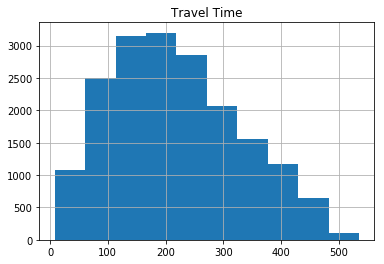

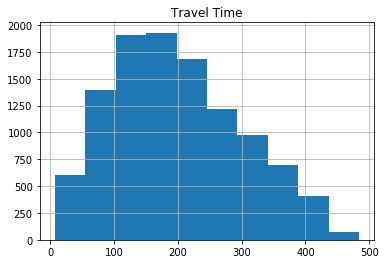

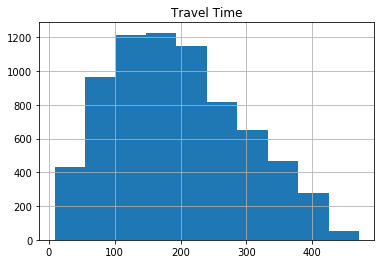

In [82]:
drone_group=df_drone_test.groupby('Drone Type')
drone_group.hist(["Travel Time"])

In [83]:
# use the slope of the regression to estimate route speed
def estimate_route_speed(dataset,x,y):
    slope, intercept, r_value, p_value, std_err = linregress(dataset[x],dataset[y])
    return slope

"route_df" is the new dataframe with Travel Time values less than 100 filtered out.

In [84]:
route_df=df_drone_test[df_drone_test["Travel Time"]>100]
route_df.shape

(30331, 19)

In [85]:
route_speeds=[]
for i in range(1,4):
    # estimate route speed for each drone type
    slope=estimate_route_speed(route_df[route_df["Drone Type"]==i],"Travel Time","Journey Distance")
    print(slope)
    route_speeds.append(slope)

1.0499762046972592
1.1495323671911641
1.183334633030317


#### iii) Estimating Beta
We can now use the estimate on-route speed to estimate the Beta signatures, using the formula I presented in the introduction, which is also defined below.

In [86]:
def calc_beta(distance,time,route_speed):
    return (distance-(time-10)*route_speed)/5

In [87]:
# calculate beta for each delivery
betas=route_df.apply(lambda x: calc_beta(x["Journey Distance"],x["Travel Time"],route_speeds[int(x["Drone Type"]-1)]),axis=1)
route_df.insert(loc=2,value=betas,column='Beta')

In [88]:
beta_test=route_df.groupby("Drone Type").describe()["Beta"]

We now have an estimate but we can do better. As we can see below, the standard deviation is fairly high compared to the mean for Drone Types 1 and 2, and there seems to exist the presence of outliers. For example, in Drone Type 1 has a max Beta of 6.10.

In [89]:
beta_test

,count,mean,std,min,25%,50%,75%,max
Drone Type,,,,,,,,
1.0,15459.0,0.658964,0.193081,0.649339,0.651577,0.652512,0.653426,12.214042
2.0,8983.0,0.745222,0.250194,-8.144744,0.748609,0.753824,0.760953,2.862898
3.0,5889.0,0.768208,0.001311,0.765326,0.767215,0.768212,0.769193,0.771029


#### iv) Improving Our Beta Estimate

In this section, we will be doing improving our Beta estimate through an iterative process:

1) Filter out all Betas which are greater than 2 SD's from the mean

2) Re-calculating the on-route speed using regression

3) Using the on-route speed estimate to calculate the new Betas

I carried out these steps until I observed an immaterial change in the Beta standard deviations.

In [90]:
# (1)
mean_betas=[]
std_betas=[]

for i in range(1,4):
    # get mean betas per drone type
    mean_betas.append(beta_test["mean"][float(i)])
    # get std of betas per drone type
    std_betas.append(beta_test["std"][float(i)])

#check which betas are greater than 2 sd's from mean    
beta_anomaly_check=route_df.apply(lambda x: delta_outlier(x["Beta"],mean_betas[int(x["Drone Type"]-1)],\
                                                                            std_betas[int(x["Drone Type"]-1)]),axis=1)

route_df=route_df[beta_anomaly_check==False]

# (2)
route_speeds=[]
for i in range(1,4):
    #get typical on route speed per drone type
    slope=estimate_route_speed(route_df[route_df["Drone Type"]==i],"Travel Time","Journey Distance")
    
    route_speeds.append(slope)
    
#(3)    
# calculate bet    
betas=route_df.apply(lambda x: calc_beta(x["Journey Distance"],x["Travel Time"],route_speeds[int(x["Drone Type"]-1)]),axis=1)

beta_test=route_df.groupby("Drone Type").describe()["Beta"]

In [91]:
beta_test

,count,mean,std,min,25%,50%,75%,max
Drone Type,,,,,,,,
1.0,15438.0,0.652503,0.001262,0.649339,0.651576,0.652511,0.653422,0.65612
2.0,8958.0,0.755245,0.008191,0.740711,0.748651,0.753848,0.760960,0.78098
3.0,5756.0,0.768217,0.001260,0.765587,0.767257,0.768218,0.769173,0.77083


In [92]:
# (1)
mean_betas=[]
std_betas=[]

for i in range(1,4):
    
    mean_betas.append(beta_test["mean"][float(i)])
    
    std_betas.append(beta_test["std"][float(i)])
    
beta_anomaly_check=route_df.apply(lambda x: delta_outlier(x["Beta"],mean_betas[int(x["Drone Type"]-1)],\
                                                                            std_betas[int(x["Drone Type"]-1)]),axis=1)

route_df=route_df[beta_anomaly_check==False]

# (2)
route_speeds=[]
for i in range(1,4):
    
    slope=estimate_route_speed(route_df[route_df["Drone Type"]==i],"Travel Time","Journey Distance")
    
    route_speeds.append(slope)
    
#(3)    
    
betas=route_df.apply(lambda x: calc_beta(x["Journey Distance"],x["Travel Time"],route_speeds[int(x["Drone Type"]-1)]),axis=1)

beta_test=route_df.groupby("Drone Type").describe()["Beta"]

In [93]:
beta_test

,count,mean,std,min,25%,50%,75%,max
Drone Type,,,,,,,,
1.0,14918.0,0.652497,0.001172,0.649979,0.651611,0.652510,0.653384,0.655025
2.0,8634.0,0.754544,0.007476,0.740711,0.748492,0.753434,0.760081,0.771621
3.0,5656.0,0.768218,0.001224,0.765698,0.767271,0.768223,0.769162,0.770735


In [94]:
# (1)
mean_betas=[]
std_betas=[]

for i in range(1,4):
    
    mean_betas.append(beta_test["mean"][float(i)])
    
    std_betas.append(beta_test["std"][float(i)])
    
beta_anomaly_check=route_df.apply(lambda x: delta_outlier(x["Beta"],mean_betas[int(x["Drone Type"]-1)],\
                                                                            std_betas[int(x["Drone Type"]-1)]),axis=1)

route_df=route_df[beta_anomaly_check==False]

# (2)
route_speeds=[]
for i in range(1,4):
    
    slope=estimate_route_speed(route_df[route_df["Drone Type"]==i],"Travel Time","Journey Distance")
    
    route_speeds.append(slope)
    
# (3)    
    
betas=route_df.apply(lambda x: calc_beta(x["Journey Distance"],x["Travel Time"],route_speeds[int(x["Drone Type"]-1)]),axis=1)

beta_test=route_df.groupby("Drone Type").describe()["Beta"]

We can see the change in the standard deviations is relatively small. We can now proceed with calculating on-speeds for each delivery in the next section.

In [95]:
beta_test

,count,mean,std,min,25%,50%,75%,max
Drone Type,,,,,,,,
1.0,14621.0,0.652497,0.001132,0.650157,0.651629,0.652510,0.653365,0.654840
2.0,8365.0,0.754030,0.007013,0.740711,0.748301,0.753106,0.759319,0.769489
3.0,5597.0,0.768214,0.001204,0.765771,0.767276,0.768216,0.769147,0.770667


#### v) Detecting Drone Type Anomalies

Now we have our Beta signatures for each Drone Type, we want to investigate for potentiat anomalies. To do this, we:

1) calculate the on-route speeds for each delivery 

2) see if any on of the on-route speeds are greated than 2 SDs from the mean

Step 2 will present our anomalies, if there are any.

In [96]:
def calc_route_speed(row,beta_list):
    beta=beta_list[int(row["Drone Type"])-1]
    return (row["Journey Distance"]-5*beta)/(row["Travel Time"]-10)

In [97]:
beta_list=[]

for i in range(1,4):
    # get mean beta for each drone type
    beta_list.append(beta_test["mean"][float(i)])

# calculate route speed for each delivery
df_drone_test.insert(loc=2,value=df_drone_test.apply(lambda x: calc_route_speed(x,beta_list) if x["Travel Time"]>10 else None,axis=1),column="route speed")

In [98]:
speed_df=df_drone_test.groupby("Drone Type")["route speed"].describe()
speed_df

,count,mean,std,min,25%,50%,75%,max
Drone Type,,,,,,,,
1.0,18314.0,1.050114,0.004477,1.014054,1.049944,1.049973,1.049995,1.190023
2.0,10878.0,1.148821,0.006102,0.929630,1.149139,1.149463,1.149632,1.184424
3.0,7247.0,1.183338,0.000272,1.171748,1.183306,1.183335,1.183363,1.192319


In [99]:
mean_speeds=[]
std_speeds=[]

for i in range(1,4):
    # mean on route speed per drone type
    mean_speeds.append(speed_df["mean"][float(i)])
    #std of route speed per drone type
    std_speeds.append(speed_df["std"][float(i)])

In [100]:
# get which route speeds are greater than 2 sd's from mean
speed_anomalies=df_drone_test[df_drone_test.apply (lambda x: \
                              delta_outlier(x["route speed"],mean_speeds[int(x["Drone Type"])-1],std_speeds[int(x["Drone Type"])-1]) \
                              if x["Travel Time"]>10 else False, axis=1) ]
speed_anomalies

,Id,Drone Type,route speed,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance,timedelta
160,ID1537857036,3.0,1.184159,0.0,41.321,47.0,47.0,-36.748357,145.946982,-36.584662,145.898851,18.722,2018-07-26,17:17:47,22.566667,17:40:21,159.43,NaN,0.000012,00:00:00.800000
684,ID1193218824,1.0,1.153685,0.0,44.681,42.0,31.0,-37.169557,145.024919,-37.911734,143.865335,131.533,2018-04-10,05:44:36,121.183333,07:45:47,138.33,NaN,-0.000281,00:00:00.400000
917,ID5367773256,3.0,1.184060,1.0,25.567,34.0,34.0,-38.917127,147.658977,-38.804200,147.579853,14.320,2018-04-23,09:04:35,18.850000,09:23:26,171.84,NaN,-0.000087,00:00:00.600000
1049,ID5738113523,3.0,1.185556,1.0,11.978,53.0,53.0,-37.116056,147.743580,-37.039680,147.777443,9.018,2018-01-13,18:21:54,14.366667,18:36:16,185.65,NaN,0.000059,00:00:00.800000
2065,ID5312797612,2.0,1.091190,1.0,35.014,27.0,27.0,-37.070602,146.385216,-37.035634,146.425975,5.316,2018-05-01,18:52:33,11.416667,19:03:58,154.14,NaN,0.000376,00:00:00.800000
2093,ID5191981367,2.0,1.136126,1.0,39.265,42.0,42.0,-37.103624,145.036568,-37.103624,144.901107,12.026,2018-05-14,11:32:42,17.266667,11:49:58,138.94,NaN,0.000327,00:00:00.200000
2178,ID1456898799,3.0,1.185121,0.0,11.313,25.0,25.0,-36.839348,146.854983,-36.934386,146.938411,12.927,2018-03-23,21:08:23,17.666667,21:26:03,171.38,NaN,-0.000411,00:00:00.800000
2186,ID5147759712,3.0,1.178194,1.0,23.299,5.0,5.0,-38.270691,146.636054,-38.235063,146.681727,5.628,2018-01-22,00:23:14,11.516667,00:34:45,198.91,NaN,-0.000442,00:00:00.200000
2681,ID1460684901,1.0,1.186123,0.0,21.951,1.0,26.0,-37.027516,143.433876,-38.847513,145.169572,253.495,2018-03-10,11:43:06,220.966667,15:24:04,158.54,NaN,0.000448,00:00:00.800000
2774,ID5118698588,1.0,1.151674,1.0,14.687,25.0,38.0,-36.951453,146.904516,-38.237203,144.108029,285.154,2018-05-26,20:29:54,254.766667,00:44:40,169.90,NaN,-0.000329,00:00:00.200000


Now we have our anomalies, how do we treat them?

The anomalies all seem to be shorter journeys. It is possible, the model is less accurate at predicting shorter length journeys.

To address, this we can test our regression without the shorter journeys and with.

For the other anomalies, we could assign the Drone Types by saying if the the route speed lies within 2 SDs of a Drone Type's mean, it belongs to that category, or we could use regression to classify the Drones.

I prefer to use the second option. If it turns out the model predicts a value of 3 for all these anomalies, then our first option would be validified. 

In [101]:
speed_anomalies.describe()

,Drone Type,route speed,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Time,Travel Time,Delivery Time,Delivery Fare,delta distance,timedelta
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167,167.000000,167,167.000000,167.000000,167
mean,2.161677,1.137767,0.335329,26.114461,25.083832,25.682635,-37.692210,145.632237,-37.713459,145.570945,75.609329,0 days 12:12:30.538922,74.337824,0 days 12:00:37.119760,147.937066,-0.000016,0 days 00:00:00.500598
std,0.696959,0.054983,0.473525,12.639233,15.550700,15.126013,0.765996,1.772076,0.750028,1.785462,115.586360,0 days 07:03:23.156819,104.610005,0 days 07:01:04.662871,31.338477,0.000287,0 days 00:00:00.290304
min,1.000000,0.929630,0.000000,5.214000,1.000000,1.000000,-39.003973,142.778869,-38.958101,142.782115,3.336000,0 days 00:02:38,10.066667,0 days 00:17:31,77.060000,-0.000497,0 days 00:00:00
25%,2.000000,1.120593,0.000000,15.332500,11.500000,12.000000,-38.379872,144.085076,-38.377530,144.083265,7.694500,0 days 06:14:11,13.466667,0 days 06:25:21.500000,124.320000,-0.000252,0 days 00:00:00.200000
50%,2.000000,1.151919,0.000000,24.519000,25.000000,25.000000,-37.646808,145.674425,-37.594953,145.601647,11.785000,0 days 12:25:28,16.816667,0 days 11:49:58,151.150000,-0.000009,0 days 00:00:00.600000
75%,3.000000,1.184067,1.000000,35.519000,37.000000,38.000000,-37.019238,147.225057,-37.061586,147.223539,118.047500,0 days 18:11:27.500000,114.908333,0 days 17:46:42.500000,169.795000,0.000222,0 days 00:00:00.800000
max,3.000000,1.192319,1.000000,58.589000,53.000000,53.000000,-36.535461,148.395586,-36.513227,148.437286,511.615000,0 days 23:32:11,451.833333,0 days 23:47:50,241.840000,0.000489,0 days 00:00:01


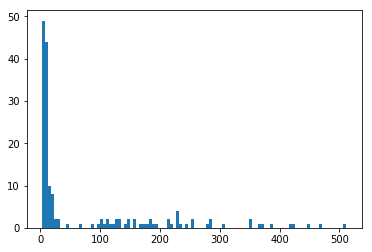

In [102]:
plt.hist(speed_anomalies['Journey Distance'],bins=100);

Looking at the histogram peak, we can remove all deliveries less than 15 from anomalies.

In [103]:
speed_anomalies_2=speed_anomalies[speed_anomalies["Journey Distance"]>15]

#### vi) Handling Shorter Length Journeys

We have to check for anomalies with those drones that travelled for less than 10 minutes. To do this we compare Beta with the double the average speed. The test is a bit flawed as we do not know the distribution between take off and landing times for these deliveries. However, we will still test it out.



In [104]:
betas=df_drone_test.apply(lambda x: calc_beta(x["Journey Distance"],x["Travel Time"],x["route speed"]) if x["Travel Time"]>10\
                   else 2*x["Journey Distance"]/x["Travel Time"],axis=1)
df_drone_test.insert(loc=2,value=betas,column='Beta')

In [105]:
beta_test=df_drone_test.groupby("Drone Type").describe()["Beta"]

In [106]:
beta_test

,count,mean,std,min,25%,50%,75%,max
Drone Type,,,,,,,,
1.0,18329.0,0.652349,0.005832,0.300124,0.652497,0.652497,0.652497,0.652497
2.0,10883.0,0.753931,0.006086,0.192270,0.754030,0.754030,0.754030,0.754030
3.0,7253.0,0.768153,0.002746,0.576224,0.768214,0.768214,0.768214,0.768214



As mentioned, this test is not very reliable, and accordingly, all Drone Types except one were considered anomalies. In any case, as we can not adequately assess the truth value of Drone Type for this category , these values will alse have to be filtered out for the regression model. We can then come back to compare these values.

In [107]:
mean_betas=[]
std_betas=[]
for i in range(1,4):
    # get mean beta for each drone type
    mean_betas.append(beta_test["mean"][float(i)])
    # get std of beta for each drone type
    std_betas.append(beta_test["std"][float(i)])
    
#check which delivery speeds were further than 2 sd's from mean
beta_anomaly_check=df_drone_test[df_drone_test["Travel Time"]<10].apply(lambda x: delta_outlier(x["Beta"],mean_betas[int(x["Drone Type"]-1)],\
                                                                            std_betas[int(x["Drone Type"]-1)]),axis=1)
beta_anomaly_check

500       True
506       True
1616      True
3695      True
4668      True
5183      True
7167      True
7545     False
8364      True
10503     True
16173     True
16547     True
16783     True
18318     True
19481     True
21734     True
26086     True
27447     True
28398     True
28614     True
30930     True
31312     True
31528     True
31771     True
33262     True
34504     True
dtype: bool

We will add all of these values to the speed_anomalies_3 dataframe and compare with speed_anomalies_2 anomalies excluding shorter length journeys) with our regression model.

In [108]:
speed_anomalies_3=pd.concat([speed_anomalies,df_drone_test[df_drone_test["Travel Time"]<10]],sort=False)

#### vii) Circling Back to Distance and Time Anomalies

Let us reassess the categorized distance and time anomalies from earlier sections.

--

Earlier, we changed the Journey Distance of the distance anomalies, to match the calculated distance from the coordinates. Now let us compare with the Drone Type to see if we made the right choice.

---

As we can see, none of the rows exhibit an anomaly when compared with Drone Type. It appears the coordinates were right.

In [109]:
da_test=df[df["Id"].isin(distance_anomalies["Id"])]

da_test["route speed"]=da_test.apply(lambda x: calc_route_speed(x, beta_list),axis=1)

# check for anomalies with drone type
da_test.apply(lambda x: delta_outlier(x["route speed"],mean_speeds[int(x["Drone Type"])-1],std_speeds[int(x["Drone Type"])-1]),axis=1)

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4373     False
10487    False
12545    False
14581    False
14599    False
14600    False
18834    False
20750    False
20751    False
22774    False
24827    False
26338    False
26856    False
29746    False
32997    False
dtype: bool

We had an issue with time anomalies whereby we were unsure if the Travel Time or the Departure/Delivery Times were inaccurate. The Travel Times were all consistent with the Drone Types. Therefore, it appears the issue may stem from one of either the Departure/Delivery Time columns.

We know the Delivery Fare is dependent on the Departure Time in terms of whether it was Morning, Afternoon or Night. Perhaps a regression model can hellp us decipher which of the Departure/Delivery Time column is inaccurate.

In [110]:
ta_test=df[df["Id"].isin(time_anomalies["Id"])]

ta_test["route speed"]=ta_test.apply(lambda x: calc_route_speed(x, beta_list),axis=1)

# check for anomalies with drone type
ta_test.apply(lambda x: delta_outlier(x["route speed"],mean_speeds[int(x["Drone Type"])-1],std_speeds[int(x["Drone Type"])-1]),axis=1)

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1555     False
2573     False
4347     False
6647     False
7278     False
8786     False
10749    False
10752    False
11013    False
12795    False
13141    False
14855    False
16902    False
16905    False
18934    False
18956    False
23646    False
33274    False
33533    False
35302    False
35313    False
dtype: bool

## 5. Coverage Anomalies

Here, we will treating fields which contain missing values using inter-column relationships.

As we can see below, there are null in the Id, Drone Type, Travel Time and Delivery Fare columns. 

We have already seen the one missing value for Id, in the Syntax Anomalies section. Hence, we will be focusing on the other columns in this section.

In [111]:
df.isna().any()

Id                        True
Drone Type                True
Post Type                False
Package Weight           False
Origin Region            False
Destination Region       False
Origin Latitude          False
Origin Longitude         False
Destination Latitude     False
Destination Longitude    False
Journey Distance         False
Departure Date           False
Departure Time           False
Travel Time               True
Delivery Time            False
Delivery Fare             True
_merge                    True
delta distance           False
timedelta                 True
dtype: bool

### a. Travel Time

This is an easy fix as we know Travel Time as the difference between the Delivery Time and the Departure Time.

In [112]:
# calculate Travel Time
def adjust_time(row):
    # deal with inter-day times
    if row["Delivery Time"]<row["Departure Time"]:
        return row["Delivery Time"]-row["Departure Time"]+pd.to_timedelta(1, unit="d")
    else:
        return row["Delivery Time"]-row["Departure Time"]

In [113]:
tt=df[df["Travel Time"].isna()]

In [114]:
tt["Travel Time"]=tt.apply(lambda x: adjust_time(x).seconds/60,axis=1)

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



We can also check for semantic anomalies with the missing values we just computed.

In [115]:
tt["route speed"]=tt.apply(lambda x: calc_route_speed(x, beta_list),axis=1)

# check for anomalies with drone type
tt_anomalies=tt.apply (lambda x: delta_outlier(x["route speed"],mean_speeds[int(x["Drone Type"])-1],std_speeds[int(x["Drone Type"])-1]) \
                              if x["Travel Time"]>10 else False, axis=1) 
tt_anomalies

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104      False
109      False
122      False
128      False
2159     False
3857     False
4231     False
4561     False
4567     False
4580     False
6246     False
6629     False
6630     False
8316     False
8656     False
8661     False
8667     False
10366    False
10710    False
12775    False
14775    False
16492    False
16510    False
18532    False
18809    False
18882    False
23000    False
23239    False
24606    False
25017    False
27734    False
29105    False
29120    False
31184    False
31767    False
32864    False
34894    False
34899    False
35263    False
36193    False
dtype: bool

The missing values all appear to exhibit no semantic anomalies. Hence, we can now adjust the Travel Time values in our dataset. 

In [116]:
df["Travel Time"]=df.apply(lambda x: fix_column(x,tt,"Travel Time",adjust_time(x)),axis=1)

### c. Building Our Regression Model

To impute the rest of our missing values, and to assess our unaddressed anomalies, we will have to build our regression model. Our regression model will be predicting Delivery Fare using selected estimators.

--
First, we have to get our dataset ready for the model. These include categorizing Departure Times, filtering out questionnable rows and finding out which columns have the most impact on Delivery Fare.

#### i) Categorize Departure Times

Departure Times are grouped into 3 categories: Morning (1), Afternoon (2) and Night (3). We will assign each Departure Time into a category.

In [117]:
def time_of_day(time):
    if time>=pd.to_timedelta("06:00:00") and time<pd.to_timedelta("12:00:00"):
        return 1
    elif time>=pd.to_timedelta("12:00:00") and time < pd.to_timedelta("21:00:00"):
        return 2
    else:
        return 3

In [118]:
df.insert(loc=3, column="time group",value=df["Departure Time"].apply(time_of_day))

In [119]:
time_group=df.groupby(df["time group"])

We can see Delivery Fare is increasing from Morning to Night.

In [120]:
time_group.describe()

Drone Type                                              Post Type  \
                count      mean       std  min  25%  50%  75%  max     count   
time group                                                                     
1              9252.0  1.687527  0.781477  1.0  1.0  1.0  2.0  3.0    9254.0   
2             13593.0  1.703082  0.782555  1.0  1.0  2.0  2.0  3.0   13596.0   
3             13696.0  1.695532  0.777859  1.0  1.0  1.0  2.0  3.0   13701.0   

                               ...           delta distance            \
                mean           ...                      75%       max   
time group                     ...                                      
1           0.299546           ...                 0.000253  0.000500   
2           0.302442           ...                 0.000250  2.899834   
3           0.299467           ...                 0.000249  1.300404   

           timedelta                                                    \
               count                      mean                     std   
time group                                                               
1               9242  -1 days +23:59:56.268102  0 days 00:07:06.277394   
2              13581  -1 days +23:59:58.060334  0 days 00:04:54.703394   
3              13688  -1 days +23:59:52.941554  0 days 00:13:12.100631   

                                                              \
                                 min                     25%   
time group                                                     
1                  -1 days +14:42:53  0 days 00:00:00.200000   
2           -1 days +19:47:10.200000  0 days 00:00:00.200000   
3           -1 days +07:44:18.600000  0 days 00:00:00.200000   

                                                            \
                               50%                     75%   
time group                                                   
1           0 days 00:00:00.400000  0 days 00:00:00.800000   
2           0 days 00:00:00.400000  0 days 00:00:00.800000   
3           0 days 00:00:00.400000  0 days 00:00:00.800000   

                                    
                               max  
time group                          
1           0 days 03:57:23.600000  
2                  0 days 06:08:00  
3           0 days 04:35:03.400000  

[3 rows x 128 columns]

#### ii) Filtering Out Anomalies

We will filter out all unadressed anomalies.

In [121]:
#drone type/speed anomalies filtered out
df_test=df[df["Id"].isin(speed_anomalies_2['Id'])==False]

#time anomalies filtered out
df_test=df_test[df_test["Id"].isin(time_anomalies['Id'])==False]

#missing values filtered out
df_test=df_test[df_test["Delivery Fare"]==df_test["Delivery Fare"]]
df_test=df_test[df_test["Drone Type"]==df_test["Drone Type"]]


In [122]:
#drone type/speed anomalies filtered out
df_test_2=df[df["Id"].isin(speed_anomalies_3['Id'])==False]

#time anomalies filtered out
df_test_2=df_test_2[df_test_2["Id"].isin(time_anomalies['Id'])==False]

#missing values filtered out
df_test_2=df_test_2[df_test_2["Delivery Fare"]==df_test_2["Delivery Fare"]]
df_test_2=df_test_2[df_test_2["Drone Type"]==df_test_2["Drone Type"]]


We will also convert travel time back to float and drop unwanted columns.

In [123]:
df_test=df_test.drop(columns=['_merge', 'delta distance', 'timedelta'])

In [124]:
df_test_2=df_test_2.drop(columns=['_merge', 'delta distance', 'timedelta'])

#### iii)  Selecting Estimators

We will be regressing each column against Delivery Fare to determine which column has a significant relationship with Delivery Fare.

In [125]:
def lin_regress(dataset,x,y):
    slope, intercept, r_value, p_value, std_err = linregress(dataset[x],dataset[y])
    line = [slope*xi + intercept for xi in dataset[x]]
    return r_value

From below the columns which we will be selecting are Drone Type, Post type, Time Group, Journey Distance. We might also expect Travel Time to exhibit a relationship with Delivery Fare; hwowever, there might be an issue of multicollinearity as Travel Time is heavily related to Drone Type and Journey Distance.

In [126]:
for column in df_test.columns[1:-1]:
    try:
        print(column,"r_value:",lin_regress(df_test,column,"Delivery Fare"))
    except:
        continue

Drone Type r_value: 0.39565421742536716
Post Type r_value: 0.21191856467526193
time group r_value: 0.13764771511701332
Package Weight r_value: 0.1897415575354106
Origin Region r_value: 0.007224059224522994
Destination Region r_value: 0.004444904940001412
Origin Latitude r_value: -0.0008890072951500268
Origin Longitude r_value: 0.002814107790804305
Destination Latitude r_value: -0.001838986890814242
Destination Longitude r_value: -0.01879446036629381
Journey Distance r_value: 0.18710209298476044


#### iv) Investigating a Potential Outliers in Delivery Fare

Looking at the histogram below, there seems to be the issue of outliers in the Delivery Fare column. This could heavily distort our regression model, and will need to be addressed.

---


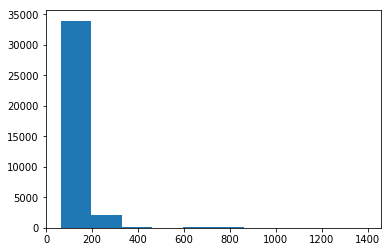

In [127]:
plt.hist(df_test["Delivery Fare"]);

In [128]:
fare_outliers=df_test[df_test["Delivery Fare"].apply(lambda x: delta_outlier(x, df_test["Delivery Fare"].mean(),df_test["Delivery Fare"].std()))]

In [129]:
fare_outliers.describe()

,Drone Type,Post Type,time group,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Time,Delivery Time,Delivery Fare
count,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339,339,339.000000
mean,1.758112,0.303835,2.120944,56.493608,26.731563,27.539823,-37.843920,145.780464,-37.830526,145.475027,234.334773,0 days 12:19:39.805309,0 days 12:16:53.902654,706.494454
std,0.777199,0.460592,0.773146,1.426448,15.667833,15.352872,0.771527,1.722215,0.777684,1.808299,105.151039,0 days 06:54:43.352361,0 days 07:02:59.799204,264.999174
min,1.000000,0.000000,1.000000,54.007000,1.000000,1.000000,-39.006932,142.772921,-39.005832,142.771421,42.377000,0 days 00:03:51,0 days 00:01:19,284.840000
25%,1.000000,0.000000,2.000000,55.337500,13.500000,14.000000,-38.519927,144.253656,-38.482587,143.784044,145.908500,0 days 06:04:55,0 days 06:23:22.500000,487.200000
50%,2.000000,0.000000,2.000000,56.489000,27.000000,29.000000,-37.938491,145.736449,-37.910225,145.549303,233.592000,0 days 12:22:08,0 days 12:25:27,696.720000
75%,2.000000,1.000000,3.000000,57.805000,40.500000,41.000000,-37.146728,147.371846,-37.161310,147.145558,300.307000,0 days 18:11:50,0 days 18:32:48.500000,887.350000
max,3.000000,1.000000,3.000000,58.998000,53.000000,53.000000,-36.512702,148.442466,-36.517474,148.448937,502.227000,0 days 23:58:54,0 days 23:55:40,1389.560000


#### v) Addressing Outliers and Building Our Model

To address the outliers, I used a bit of trial and error.

First, I looked the histogram to select from the area where the second group seems to beging.

Then, I tried using the minimum value of the outlier dataset ("fare_outliers") as a delimiter.

The regression score improved dramatically, and so now I have to split my dataset into two. I noticed all members of the second group tend to have a heavier Package Weight from the early 50's. So I toyed around with the weight delimiter until I got what was the highest regression score.

In [130]:
def regress_fare(df):
    X_train, X_test, y_train, y_test = train_test_split(df[["Drone Type","Post Type","Package Weight","Journey Distance","time group"]],df.iloc[:,-1:], random_state = 1)
    map(pd.np.shape,[X_train, X_test, y_train, y_test])
    lm_reg = LinearRegression()
    lm_reg.fit(X_train,y_train)

    print ('r-squared for this model = ',lm_reg.score(X_test,y_test))
    return lm_reg

In [131]:
df_test_extraordinary=df_test[df_test["Delivery Fare"]>=580]
df_test_reg=df_test[df_test["Delivery Fare"]<580]

In [132]:
regress_fare(df_test_extraordinary)
regress_fare(df_test_reg)

r-squared for this model =  0.9988532108898328
r-squared for this model =  0.7810309369841286


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
df_test_extraordinary=df_test[df_test["Delivery Fare"]>=284]
df_test_reg=df_test[df_test["Delivery Fare"]<284]

In [134]:
regress_fare(df_test_extraordinary)
regress_fare(df_test_reg)

r-squared for this model =  0.99928187535086
r-squared for this model =  0.9840089612011772


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The final regression score was 0.99 for the standard fares and 1.0 for the outstanding fares.

In [135]:
df_tes t_extraordinary=df_test[df_test["Package Weight"]>=54]
df_test_reg=df_test[df_test["Package Weight"]<54]

In [136]:
reg_high=regress_fare(df_test_extraordinary)
reg_norm=regress_fare(df_test_reg)

r-squared for this model =  0.9993284028089299
r-squared for this model =  0.991072186700917


Now let us test his model without the shorter length journeys included.

---

The score actually went down, so we will be using the model with the shorter length journeys included.

In [137]:
df_test_2_extraordinary=df_test_2[df_test_2["Package Weight"]>=54]
df_test_2_reg=df_test_2[df_test_2["Package Weight"]<54]

reg_high=regress_fare(df_test_2_extraordinary)
reg_norm=regress_fare(df_test_2_reg)

r-squared for this model =  0.9990343567574423
r-squared for this model =  0.9906874269922781


#### vi) Imputing Delivery Fare

We will use our model to impute the missing values in Delivery Fare

In [138]:
def impute_fare(row):
    parameters=np.array([row[["Drone Type","Post Type","Package Weight","Journey Distance","time group"]]])
    if row["Package Weight"]<54:
        return round(reg_norm.predict(parameters)[0][0],2)
    else:
        return round(reg_high.predict(parameters)[0][0],2)

In [139]:
df["Delivery Fare"]=df.apply(lambda x: x["Delivery Fare"]if x["Delivery Fare"]==x["Delivery Fare"] else impute_fare(x),axis=1)

#### vii) Imputing Drone Type and Re-assessing Drone Type Anomalies

The method for imputing Drone Type is not perfect, as I am using a regression model for a classification problem. However, we can round the output to the nearest syntactically valid number, and use that to impute our Drone Type.

We will use this to impute missing Drone Type values and re-assess the anomalies we encountered in the Drone Type column.

In [140]:
def regress_drone(df):
    X_train, X_test, y_train, y_test = train_test_split(df[["Delivery Fare","Post Type","Package Weight","Journey Distance","time group"]],df["Drone Type"], random_state = 1)
    map(pd.np.shape,[X_train, X_test, y_train, y_test])
    lm_reg = LinearRegression()
    lm_reg.fit(X_train,y_train)
    return lm_reg

In [141]:
def impute_drone(row):
    parameters=np.array([row[["Delivery Fare","Post Type","Package Weight","Journey Distance","time group"]]])
    if row["Package Weight"]<54:
        value= regress_drone(df_test_reg).predict(parameters)[0]
    else:
        value= regress_drone(df_test_extraordinary).predict(parameters)[0]
    output=float(round(value))
    if output==0.0:
        return 1.0
    if output==4.0:
        return 3.0
    return output

In [142]:
missing_drone=df[df["Drone Type"].isna()]

In [143]:
speed_anomalies_2['time group']=speed_anomalies_2['Departure Time'].apply(time_of_day)

speed_anomalies_2.insert(loc=1, value=speed_anomalies_2.apply(impute_drone,axis=1), column="Impute Drone")

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



According to our regression model, 52 of the 71 speed_anomalies_2 dataset were actual anomalies. 

In [144]:
# check with deliveries had drone type different from predicted drone type
speed_anomalies_4=speed_anomalies_2[speed_anomalies_2.apply(lambda x: False if x["Impute Drone"]==x["Drone Type"] else True, axis=1)]
speed_anomalies_4

,Id,Impute Drone,Drone Type,route speed,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,...,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance,timedelta,time group
684,ID1193218824,2.0,1.0,1.153685,0.0,44.681,42.0,31.0,-37.169557,145.024919,...,131.533,2018-04-10,05:44:36,121.183333,07:45:47,138.33,NaN,-0.000281,00:00:00.400000,3
2681,ID1460684901,3.0,1.0,1.186123,0.0,21.951,1.0,26.0,-37.027516,143.433876,...,253.495,2018-03-10,11:43:06,220.966667,15:24:04,158.54,NaN,0.000448,00:00:00.800000,1
2774,ID5118698588,2.0,1.0,1.151674,1.0,14.687,25.0,38.0,-36.951453,146.904516,...,285.154,2018-05-26,20:29:54,254.766667,00:44:40,169.90,NaN,-0.000329,00:00:00.200000,2
6792,ID1856002717,1.0,2.0,1.048503,0.0,23.393,31.0,29.0,-37.841831,143.523184,...,364.595,2018-06-06,08:21:27,354.133333,14:15:35,101.63,NaN,-0.000439,00:00:00.400000,1
6870,ID1370051615,1.0,2.0,1.048601,0.0,40.517,49.0,19.0,-36.567722,147.162586,...,388.362,2018-01-16,13:09:04,376.766667,19:25:50,119.41,NaN,0.000185,00:00:00.200000,2
6899,ID1478538536,1.0,2.0,1.041670,0.0,47.635,52.0,29.0,-38.068577,146.773619,...,67.503,2018-06-12,13:31:36,71.183333,14:42:47,88.85,NaN,-0.000260,00:00:00.400000,2
7121,ID1445535239,1.0,2.0,1.048771,0.0,47.155,36.0,49.0,-38.588119,142.778869,...,446.002,2018-02-11,05:45:38,431.666667,12:57:18,137.49,NaN,0.000480,00:00:00.200000,3
7878,ID5660508057,3.0,1.0,1.184695,1.0,22.137,45.0,30.0,-36.669445,148.184504,...,511.615,2018-06-22,02:33:39,439.100000,09:52:45,241.84,NaN,0.000117,00:00:00.600000,3
8816,ID1312163704,3.0,1.0,1.185817,0.0,12.083,26.0,37.0,-38.928753,145.052558,...,284.143,2018-07-04,05:44:19,246.866667,09:51:11,185.08,NaN,-0.000452,00:00:00.800000,3
8954,ID1460192751,1.0,2.0,1.044707,0.0,30.834,34.0,43.0,-38.868044,147.800667,...,104.062,2018-02-08,06:18:59,106.000000,08:04:59,82.22,NaN,-0.000290,00:00:00.600000,1


In [145]:
drones_to_fix=pd.concat([missing_drone,speed_anomalies_4],sort=False)

In [146]:
# change drone types for anomalies
df["Drone Type"]=df.apply(lambda x: fix_column(x,drones_to_fix,"Drone Type",impute_drone(x)),axis=1)

#### vii) Addressing Time Anomalies

For our time anomalies, we were unsure of whether to fix the Delivery Time or the Departure time. Perhaps the time group could help us determine which to fix. If the time group matches predicted time group, I will assume Departure Time is correct. Otherwise, it will depend on the relationship between the predicted time group and the proposed Departure time. This will be explained when we encounter these cases below.

---
Similarly to predicting Drone Types, we will round to nearest syntactically valid number.

In [147]:
def regress_time_group(df):
    X_train, X_test, y_train, y_test = train_test_split(df[["Delivery Fare","Post Type","Package Weight","Journey Distance","Drone Type"]],df["time group"], random_state = 1)
    map(pd.np.shape,[X_train, X_test, y_train, y_test])
    lm_reg = LinearRegression()
    lm_reg.fit(X_train,y_train)
    return lm_reg

In [148]:
def impute_time_group(row):
    parameters=np.array([row[["Delivery Fare","Post Type","Package Weight","Journey Distance","Drone Type"]]])
    if row["Package Weight"]<54:
        value=regress_time_group(df_test_reg).predict(parameters)[0]
    else:
        value= regress_time_group(df_test_extraordinary).predict(parameters)[0]
    output=int(round(value))
    #if the model rounds down to 0, we will assume it is a Drone Type of 1.
    if output==0:
        return 1
    if output==4:
        return 3
    return output

In [149]:
time_test=time_anomalies

#add time group column
time_test['time group']=time_test['Departure Time'].apply(time_of_day)
#add predicted time group column
time_test["Impute Time Group"]=time_test.apply(impute_time_group,axis=1)

time_test

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\YOU\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,...,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance,timedelta,time group,Impute Time Group
1555,ID5342374365,2.0,1.0,46.425,7.0,33.0,-37.908448,142.833274,-37.001757,144.321360,...,2018-03-04,20:36:32,02:30:57,01:02:33,171.21,NaN,0.000348,-1 days +22:04:56,2,2
2573,ID1673711651,1.0,0.0,11.404,5.0,14.0,-38.350520,146.524295,-38.257363,143.068411,...,2018-03-09,05:40:51,04:54:34.199999,07:30:49,117.13,NaN,-0.000407,03:04:36.199999,3,3
4347,ID5954397057,1.0,1.0,47.401,9.0,35.0,-36.738648,145.086947,-38.785307,148.248959,...,2018-05-07,05:45:23,05:49:22.200000,07:23:36,163.46,NaN,-0.000464,04:11:09.200000,3,3
6647,ID5686884495,2.0,1.0,27.098,15.0,4.0,-38.009543,144.965771,-36.581461,144.091139,...,2018-04-22,03:50:42,02:40:34.800000,03:59:51,175.31,NaN,-0.000101,02:31:25.800000,3,3
7278,ID1488334618,2.0,0.0,6.435,31.0,51.0,-37.872869,143.786664,-38.340430,147.603228,...,2018-03-28,00:08:42,05:00:59.400000,02:32:05,155.41,NaN,-0.000491,02:37:36.400000,3,3
8786,ID5578789181,3.0,1.0,41.770,44.0,50.0,-38.437486,148.319547,-36.629571,142.955681,...,2018-02-15,06:01:59,07:21:27,22:40:33,249.29,NaN,-0.000395,-1 days +14:42:53,1,3
10749,ID1218721228,2.0,0.0,27.074,2.0,20.0,-37.601522,146.792232,-38.741506,145.625645,...,2018-07-17,14:37:48,02:28:25.800000,20:58:52,138.27,NaN,-0.000292,-1 days +20:07:21.800000,2,2
10752,ID1173614446,1.0,0.0,14.646,8.0,16.0,-38.002563,148.285512,-37.164040,147.371294,...,2018-02-01,23:33:33,02:04:23.400000,04:56:05,109.06,NaN,-0.000150,-1 days +20:41:51.400000,3,3
11013,ID5530128644,1.0,1.0,11.292,15.0,45.0,-38.248848,144.893186,-36.725199,147.866499,...,2018-02-15,01:11:08,05:04:37.800000,20:06:31,140.75,NaN,0.000314,-1 days +10:09:14.800000,3,2
12795,ID5819400810,1.0,1.0,11.428,6.0,12.0,-38.484914,143.668120,-37.319998,148.170934,...,2018-02-26,09:07:43,06:43:15.600000,11:53:35,138.95,NaN,0.000459,03:57:23.600000,1,1


In [150]:
# time group equals predicted time group
fix_del= time_test[time_test["Impute Time Group"]==time_test["time group"]]

# time group does not equal predicted time group
fix_others= time_test[time_test["Impute Time Group"]!=time_test["time group"]]

So we have four rows in which the predicted time group does not match the implied time group. 

* row 1: This is likely a slight error in the regression as the implied new Departure Time using the Departure time would not align with the predicted time group. Hence, we will assume Departure Time is correct.

* rows 2, 3 and 4: The implied new Delivery Time would align with the predicted time group. Here, we will assume the Delivery Time is correct.


In [151]:
fix_others

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,...,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare,_merge,delta distance,timedelta,time group,Impute Time Group
8786,ID5578789181,3.0,1.0,41.770,44.0,50.0,-38.437486,148.319547,-36.629571,142.955681,...,2018-02-15,06:01:59,07:21:27,22:40:33,249.29,NaN,-0.000395,-1 days +14:42:53,1,3
11013,ID5530128644,1.0,1.0,11.292,15.0,45.0,-38.248848,144.893186,-36.725199,147.866499,...,2018-02-15,01:11:08,05:04:37.800000,20:06:31,140.75,NaN,0.000314,-1 days +10:09:14.800000,3,2
13141,ID1283187537,1.0,0.0,29.887,4.0,32.0,-36.692581,143.964196,-37.040500,148.399772,...,2018-04-27,01:17:56,06:24:52.800000,18:53:04,118.94,NaN,-0.000232,-1 days +12:49:44.800000,3,2
33533,ID1708334056,2.0,0.0,42.003,50.0,48.0,-36.771364,142.963543,-38.847008,144.298055,...,2018-04-25,00:41:26,03:52:09.600000,20:49:17,147.52,NaN,-0.000049,-1 days +07:44:18.600000,3,2


In [152]:
fix_del=fix_del.append(fix_others[fix_others["Id"]=="ID5578789181"])
fix_dep=fix_others[fix_others["Id"]!="ID5578789181"]

In [153]:
# fix delivery time  
df["Delivery Time"]=df.apply(lambda x: x["Departure Time"]+pd.to_timedelta(x["Travel Time"],unit="m") if x["Id"] in fix_del["Id"].values\
                             else x["Delivery Time"], axis=1)

In [154]:
#fix departure time
df["Departure Time"]=df.apply(lambda x: x["Delivery Time"]-pd.to_timedelta(x["Travel Time"],unit="m")if x["Id"] in fix_dep["Id"].values\
                              else x["Departure Time"], axis=1)

## 6. Normalizing and Outputting Dataset

In this section we will be normalizing the dataset to the structure of the one we loaded then outputting the dataset as a csv file. To do this we will:

1) Drop added columns

2) Set Id to index

3) Normalize Time

4) Rounds numbers to original d.p's

5) output file

In [155]:
# 1
df=df.drop(columns=['_merge', 'delta distance','timedelta','time group'])

In [156]:
# 2
df=df.set_index("Id")

In [157]:
# 3
def extract_time(x):
    return str(x).split(" days ")[1]

df["Delivery Time"]=df["Delivery Time"].apply(extract_time)

df["Departure Time"]=df["Departure Time"].apply(extract_time)

In [158]:
# 4
df["Travel Time"]=df["Travel Time"].apply(lambda x: round(pd.to_timedelta(x,unit='m').seconds/60,2))

df["Journey Distance"]=df["Journey Distance"].apply(lambda x: round(x,3))

In [161]:
# 5
df.to_csv("29466695_solution")

In [19]:
df2=pd.read_csv("clean.csv")

In [20]:
x= ['ID5398618539', 'ID1427304163', 'ID1858755899', 'ID1436660051', 'ID5452748869', 'ID1549587650', 'ID1192467105', 'ID1461460647', 'ID1412126065', 'ID1567648303', 'ID5942714527', 'ID1815575369', 'ID1555368482', 'ID5459159549', 'ID1932758006', 'ID1387042148', 'ID1587747703', 'ID5320471446', 'ID1925173024', 'ID1740813591', 'ID5645436993', 'ID1373629507', 'ID1533940549', 'ID5383564392', 'ID1967162132', 'ID1228266829', 'ID5359367509', 'ID1111474479', 'ID5594359817', 'ID1658720730', 'ID1353328331', 'ID1983843173', 'ID1850342249', 'ID1950792847', 'ID1799594017', 'ID1864610666', 'ID1507490034', 'ID1759911724', 'ID1946246775', 'ID1801022997', 'ID1997888143', 'ID1459999017', 'ID5749180073', 'ID1742890116', 'ID1760941408', 'ID5512338833', 'ID1126042891', 'ID5299470803', 'ID1384279876', 'ID1827788069', 'ID5424207123', 'ID1111430722', 'ID1189250970', 'ID1474218968', 'ID5180227047', 'ID1910021359', 'ID1796496243', 'ID5375899156', 'ID1164466088', 'ID1495121896', 'ID5786526543', 'ID5119871154', 'ID1402746891', 'ID1513758861', 'ID1275986925', 'ID5506537778', 'ID1664214187', 'ID1128319064', 'ID1141750305', 'ID1247920662', 'ID1992445778', 'ID5784187103', 'ID5463940736', 'ID5611892724', 'ID1450952426', 'ID1939133934', 'ID1965213613', 'ID5932920065', 'ID1322087297', 'ID1995756120', 'ID5688141819', 'ID1593334324', 'ID1516611970', 'ID1287682688', 'ID1974726136', 'ID1271701665', 'ID5756225282', 'ID1557968337', 'ID5654020027', 'ID1147425992', 'ID1336349537', 'ID5424541157', 'ID1612579998', 'ID1122758565', 'ID1788446957', 'ID1204455356', 'ID5271064086', 'ID1658748725', 'ID1721247114', 'ID1444743458', 'ID1218614811', 'ID1191110940', 'ID5434815776']

In [77]:
df[df["Id"].isin(x)].sort_values("Id")

,Id,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Travel Time,Delivery Time,Delivery Fare
17342,ID1111430722,2.0,0.0,11.710,7.0,6.0,-37.887805,142.918234,-38.478616,143.783631,100.294,2018-06-24,23:23:59,94.02,0:58:00,139.37
9104,ID1111474479,1.0,0.0,12.943,35.0,40.0,-38.924716,148.208275,-37.626131,146.522162,206.407,2018-02-20,09:04:07,203.48,12:27:35,90.30
35015,ID1122758565,1.0,0.0,36.295,20.0,15.0,-38.749714,145.745848,-38.050591,145.032425,99.649,2018-06-21,07:31:57,101.81,9:13:45,84.80
15438,ID1126042891,1.0,0.0,25.348,38.0,47.0,-38.273259,143.890810,-36.685952,145.834328,246.355,2018-06-16,17:14:42,241.53,21:16:13,101.05
23513,ID1128319064,2.0,0.0,12.609,6.0,47.0,-38.388951,143.492175,-36.823386,145.718603,262.515,2018-05-22,21:46:01,235.09,1:41:06,152.09
23535,ID1141750305,1.0,0.0,12.515,33.0,20.0,-36.930719,144.387634,-38.756446,145.641434,231.190,2018-01-18,06:55:20,227.09,10:42:25,86.96
31867,ID1147425992,1.0,0.0,36.247,49.0,16.0,-36.570353,147.014187,-37.345504,147.552964,98.703,2018-02-21,08:38:20,100.91,10:19:14,84.50
19467,ID1164466088,2.0,0.0,23.972,40.0,36.0,-37.592671,146.250173,-38.791024,142.787578,330.979,2018-05-25,18:38:23,294.62,23:33:00,145.58
17477,ID1189250970,3.0,0.0,29.720,13.0,50.0,-37.869927,144.404991,-36.865822,142.776560,182.337,2018-03-18,14:30:58,160.85,17:11:48,165.48
36240,ID1191110940,1.0,0.0,47.357,9.0,39.0,-36.841792,145.174864,-38.476444,145.308002,182.342,2018-06-16,16:19:06,180.56,19:19:39,101.80


In [47]:
df2[df2["Unnamed: 0.1"].isin(x)].sort_values("Unnamed: 0.1")

,Unnamed: 0,Unnamed: 0.1,Outlier Weight,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Day Time,Travel Time,Delivery Time,Delivery Fare
17342,17342,ID1111430722,54,2,0,11.710,7,6,-37.887805,142.918234,-38.478616,143.783631,100.294,2018-06-24,23:23:59,3,94.02,0:58:00,139.37
9104,9104,ID1111474479,54,1,0,12.943,35,40,-38.924716,148.208275,-37.626131,146.522162,206.407,2018-02-20,09:04:07,1,203.48,12:27:35,90.30
35015,35015,ID1122758565,54,1,0,36.295,20,15,-38.749714,145.745848,-38.050591,145.032425,99.649,2018-06-21,07:31:57,1,101.81,9:13:45,84.80
15438,15438,ID1126042891,54,1,0,25.348,38,47,-38.273259,143.890810,-36.685952,145.834328,246.355,2018-06-16,17:14:42,2,241.53,21:16:13,101.05
23513,23513,ID1128319064,54,2,0,12.609,6,47,-38.388951,143.492175,-36.823386,145.718603,262.515,2018-05-22,21:46:01,3,235.09,1:41:06,152.09
23535,23535,ID1141750305,54,1,0,12.515,33,20,-36.930719,144.387634,-38.756446,145.641434,231.190,2018-01-18,06:55:20,1,227.09,10:42:25,86.96
31867,31867,ID1147425992,54,1,0,36.247,49,16,-36.570353,147.014187,-37.345504,147.552964,98.703,2018-02-21,08:38:20,1,100.91,10:19:14,84.50
19467,19467,ID1164466088,54,2,0,23.972,40,36,-37.592671,146.250173,-38.791024,142.787578,330.979,2018-05-25,18:38:23,2,294.62,23:33:00,145.58
17477,17477,ID1189250970,54,3,0,29.720,13,50,-37.869927,144.404991,-36.865822,142.776560,182.337,2018-03-18,14:30:58,2,160.85,17:11:48,165.48
36240,36240,ID1191110940,54,1,0,47.357,9,39,-36.841792,145.174864,-38.476444,145.308002,182.342,2018-06-16,16:19:06,2,180.56,19:19:39,101.80


In [27]:
df2

,Unnamed: 0,Unnamed: 0.1,Outlier Weight,Drone Type,Post Type,Package Weight,Origin Region,Destination Region,Origin Latitude,Origin Longitude,Destination Latitude,Destination Longitude,Journey Distance,Departure Date,Departure Time,Day Time,Travel Time,Delivery Time,Delivery Fare
0,0,ID1574983598,54,1,0,31.219,11,44,-36.600581,146.327914,-38.518996,148.203069,270.142,2018-03-03,08:18:38,1,264.18,12:42:48,95.91
1,1,ID1750957119,54,1,0,23.799,49,37,-36.540818,147.326229,-36.544820,143.467588,345.069,2018-07-11,10:27:18,1,335.54,16:02:50,97.84
2,2,ID5393864916,54,3,1,46.503,40,29,-37.494093,146.189957,-37.676371,147.488746,116.352,2018-04-26,14:54:12,2,105.09,16:39:17,200.90
3,3,ID5698348730,54,1,1,33.596,48,40,-38.896284,144.484038,-37.449914,146.449348,235.578,2018-01-08,17:18:04,2,231.26,21:09:19,133.94
4,4,ID1111487122,54,2,0,9.516,25,44,-37.059112,146.937517,-38.584440,148.311254,208.373,2018-05-12,00:46:04,3,188.01,3:54:04,150.52
5,5,ID1448023214,54,3,0,33.208,3,26,-37.222026,144.333883,-38.899449,145.170401,200.601,2018-03-12,09:05:44,1,176.28,12:02:00,164.34
6,6,ID1712938360,54,1,0,14.188,23,29,-38.367299,145.735988,-37.941922,147.453534,157.621,2018-06-03,23:26:57,3,157.02,2:03:58,111.26
7,7,ID5718151743,54,1,1,27.883,5,13,-38.197489,146.456309,-37.768187,144.420409,184.906,2018-02-22,03:02:51,3,183.01,6:05:51,145.95
8,8,ID1237455574,54,3,0,37.254,35,49,-38.890908,148.210275,-36.620046,147.262865,266.178,2018-05-23,11:05:22,1,231.70,14:57:03,163.10
9,9,ID1145795589,54,1,0,38.298,51,51,-38.507676,147.658700,-38.291806,147.759362,25.584,2018-04-05,00:21:08,3,31.27,0:52:24,103.16


## References:

Michael0x2a (2013, October 16). **getting-distance-between-two-points-based-on-latitude-longitude**. Retrieved from http://stackoverflow.com/a/44781https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude